<a href="https://colab.research.google.com/github/Steve-YJ/Colab_Exercise/blob/master/Again_Training_Exp06_continue_Exp05_from_10Epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README.MD
* Try Again, Fin...Fin...Fin...!!
* back to Original Kingma's VAE to Malimg
    * optimizer learning rate: 1e-3
    * optimizer params: sum
* Add 
    * plot train, test loss
        * save it every Epochs
    * plot latent vector per 10 Epoch
        * save it every 10 Epoch
    * save model's state dict per 10 Epoch
    * save latent vector per 10 Epoch

    * Change plot: add alpha parameter for visualization
* ✅ Check Point
    * Keep training Exp05
        * After Epoch 10, Train it
        * Reduce Learning rate: 1e-5 to 1e-3


## Reference
* Reference repository: https://github.com/pytorch/examples/tree/master/vae

* Reference for Visualization: https://github.com/tayden/VAE-Latent-Space-Explorer/blob/master/scripts/VAE.ipynb


In [1]:
! nvidia-smi

Sun Jul  5 00:20:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# drive mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
%cd drive/My\ Drive/InfoSec_Summer_part2
! pwd

/content/drive/My Drive/InfoSec_Summer_part2
/content/drive/My Drive/InfoSec_Summer_part2


## 01. Import Library

In [5]:
from PIL import Image
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
 
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
import seaborn as sns

# save single numpy array
# https://numpy.org/doc/stable/reference/generated/numpy.save.html#numpy.save
from tempfile import TemporaryFile
from sklearn.manifold import TSNE

import torch
import torch.utils.data

from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 02. Data Preprocessing
* Load dataset
* preprocess it
    * transforms
    * make custom dataset
    * train_test split: <code>torch.utils.data.random_split</code>
    * train_test_loader

### Work Flow
* transforms module 사용해서 image data compose 하기
    * size 조정, normalize, tensor 변환
* ImageFolder를 이용해 dataload
* dataset split: train dataset, test dataset
* DataLoader로 batch단위 dataset 불러오기

In [6]:
transforms = transforms.Compose([
                                transforms.Resize((224, 224)),                # Change size of Image to (224, 224)
                                transforms.Grayscale(num_output_channels=1),  # Makes it 1-dimension channel
                                transforms.ToTensor(),                        # Convert a PIL Image or numpy.ndarray to tensor.
                                                                              # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8
                                                                              # In the other cases, tensors are returned without scaling.
                                # transforms.Normalize(mean=[0.5], std=[0.5]),
                                
                                ])

# make custom dataset
trainset = torchvision.datasets.ImageFolder(root='../InformationSecurity_Summer/malimg',
                                            transform=transforms)  # make custom dataset

In [7]:
trainset

Dataset ImageFolder
    Number of datapoints: 9339
    Root location: ../InformationSecurity_Summer/malimg
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               Grayscale(num_output_channels=1)
               ToTensor()
           )

In [8]:
# classes = trainset.classes
classes = trainset.classes
classes

['Adialer.C',
 'Agent.FYI',
 'Allaple.A',
 'Allaple.L',
 'Alueron.gen!J',
 'Autorun.K',
 'C2LOP.P',
 'C2LOP.gen!g',
 'Dialplatform.B',
 'Dontovo.A',
 'Fakerean',
 'Instantaccess',
 'Lolyda.AA1',
 'Lolyda.AA2',
 'Lolyda.AA3',
 'Lolyda.AT',
 'Malex.gen!J',
 'Obfuscator.AD',
 'Rbot!gen',
 'Skintrim.N',
 'Swizzor.gen!E',
 'Swizzor.gen!I',
 'VB.AT',
 'Wintrim.BX',
 'Yuner.A']

In [9]:
full_dataset = trainset
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
print(train_size, test_size)

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

7471 1868


In [10]:
'''
for idx, (data, _) in enumerate(test_dataset):
    if idx == 5: 
        break
    else:
        print(data, _)
'''

'\nfor idx, (data, _) in enumerate(test_dataset):\n    if idx == 5: \n        break\n    else:\n        print(data, _)\n'

In [11]:
train_loader = DataLoader(train_dataset,
                         batch_size=16,
                         shuffle=True,
                         pin_memory=True) 
test_loader = DataLoader(test_dataset,
                        batch_size=16,
                        shuffle=True,
                        pin_memory=True)  # Instead, we recommend using automatic memory pinning (i.e., setting pin_memory=True)
                                          #  which enables fast data transfer to CUDA-enabled GPUs

# First, insert all test dataset
# test_loader_10: testloader for latent vector visualization
test_loader_10 = DataLoader(test_dataset,
                        batch_size=1868,
                        shuffle=True,
                        pin_memory=True)

In [12]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    np_img = img.numpy()

    plt.imshow(np.transpose(np_img, (1, 2, 0)))  # Convert (C, W, H) to (W, H, C)

    print(np_img.shape)  # np_img shape
    print((np.transpose(np_img, (1, 2, 0))).shape)  # transposed shape 

In [13]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)

tensor([ 3, 22, 24, 24, 10, 17,  2,  1,  2, 15,  2, 11,  2,  2,  3,  3])


torch.Size([16, 1, 224, 224])
(3, 906, 906)
(906, 906, 3)
torch.Size([16, 1, 224, 224])
torch.Size([3, 454, 1810])
Allaple.L VB.AT Yuner.A Yuner.A Fakerean Obfuscator.AD Allaple.A Agent.FYI Allaple.A Lolyda.AT Allaple.A Instantaccess Allaple.A Allaple.A Allaple.L Allaple.L 


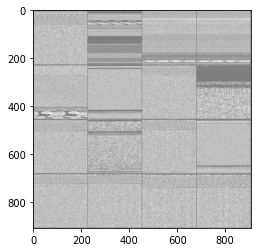

In [14]:
print(images.shape)
imshow(torchvision.utils.make_grid(images, nrow=4))
print(images.shape)
print((torchvision.utils.make_grid(images)).shape)
print("".join("%5s "%classes[labels[j]] for j in range(16)))

## 03. Define VAE Class
* Initialize
    * (224, 224) input 이미지를 통해 1차원 100개의 latent vector를 생성하는 Encoder네트워크 정의
    * 100개의 latent vector로부터 X_hat을 복원하는 Decoder Network 정의
* encode
* reparameterize
* decode
* forward

In [15]:
device = torch.device("cuda")  # device = torch.device("cuda")

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(224*224, 1000)
        self.fc21 = nn.Linear(1000, 100)
        self.fc22 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 1000)
        self.fc4 = nn.Linear(1000, 224*224)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
# loss값이 안줄면 sigmoid함수를 제거하고 BCE with Logits Loss를 사용해볼까?
# https://nuguziii.github.io/dev/dev-002/

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 224*224))
        z = self.reparameterize(mu, logvar)  # z's shape => (batch_size, 100)
        return self.decode(z), mu, logvar, z

### Load State Dict
* Exp05_Epoch10
* <code>Exp05_model_save_10Epochs.pth</code>

In [17]:
# Load State_dict
PATH_State_Dict = './Exp06_results/Exp05_model_save_10Epochs.pth'

model = VAE().to(device)
model.load_state_dict(torch.load(PATH_State_Dict))
model.eval

model

VAE(
  (fc1): Linear(in_features=50176, out_features=1000, bias=True)
  (fc21): Linear(in_features=1000, out_features=100, bias=True)
  (fc22): Linear(in_features=1000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=50176, bias=True)
)

In [18]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [19]:
get_n_params(model)  

100704376

*Note*<br>
✅ Reducing Learning rate<br>
1e-3 to 1e-5

In [20]:
optimizer = optim.Adam(model.parameters(), lr=1e-5)  # reducing learning rate after 10 Epochs

In [21]:
# track and save train, test loss through Dictionary
# 
Epoch_Loss = {'train_epoch':[],
              'train_loss':[],
              'test_epoch':[],
              'test_loss':[]}

# Save & Loading Model for Inference
# Reference: https://pytorch.org/tutorials/beginner/saving_loading_models.html

# PATH = '/Again_original_Exp01_200-Epoch.pth'

PATH = 'Epochs.pth'
# latent_vector = np.zeros((16, 100))
color_palette = np.zeros((1868))


In [22]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 224*224), reduction='sum')  # (input, target, ... reduction)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

def train(epoch):
    model.train()
    train_loss = 0
    # latent_vector = np.zeros(())
    # latent_label = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, z= model(data)
    
       
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    
    Epoch_Loss['train_epoch'].append(epoch)
    Epoch_Loss['train_loss'].append(train_loss / len(train_loader.dataset))
   
def test(epoch):
    # 10 Epoch 단위로 작업
    # model.state_dict() 저장 및 latent_vector 저장
    # plot latent vector
    if epoch % 10 == 0:  # Epoch이 10의 배수일때
     # save model.state_dict() per 10 Epochs
        torch.save(model.state_dict(), ('./Exp06_results/model_save_' + str(epoch) + PATH))  # Epoch 단위 parameter 저장

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for i, (data, _) in enumerate(test_loader):
                data = data.to(device)
                recon_batch, mu, logvar, z = model(data)
                # z vector는 torch type
                # latent_vector = z.detach().cpu().clone().numpy()
                test_loss += loss_function(recon_batch, data, mu, logvar).item()
                if i == 0:
                    n = min(data.size(0), 8)
                    comparison = torch.cat([data[:n],
                                        recon_batch.view(16, 1, 224, 224)[:n]])
                    save_image(comparison.cpu(),
                            './Exp06_results/recon_sampling/reconstruction_' + str(epoch) + '.png', nrow=n)
        test_loss /= len(test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))
        Epoch_Loss['test_epoch'].append(epoch)
        Epoch_Loss['test_loss'].append(test_loss)

        # save latent vector's every 10 Epoch's
        # load_whole test_data 
        for i, (data, _) in enumerate(test_loader_10):  # load_whole test_data
            data = data.to(device)
            recon_batch, mu, logvar, z = model(data)
        # save latent_vector per 10 Epochs
            latent_vector = z.detach().cpu().clone().numpy()  # change tensor type data to cpu().numpy()
                                                              # latent_vector_size: (num_of_data, 100)
            color_palette = _.detach().cpu().clone().numpy()
            with open(('./Exp06_results/'+str(epoch)+'Epoch_z_vector.npy'), 'wb') as f:
                np.save(f, latent_vector)  # but latent vector size is (16, 100).... just 16...
                                           # 10 Epoch 단위로 latent vector를 저장한다
                                           # 이 떄, latent vector의 size는 test_dataset의 크기가 되어야 한다
                                           # 결과값이 좋은 vector는 좋은 feature로 사용할 수 있다.
        # plot latent vector Every 10 Epochs
        # t-SNE for Dimensionality reduction
        Z_embedded = TSNE(n_components=2).fit_transform(latent_vector)
        
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))  # setup the plot

        x = Z_embedded[:, 0]
        y = Z_embedded[:, 1]
        label = color_palette
        # label[10:12] = 0  # make sure there are some 0 values to show up as grey
        print("=="*20, "params", "=="*20)
        print("Z_embedded.shape:", Z_embedded.shape)
        print("label.shape:", label.shape)
        # tsne_data = np.vstack((Z_embedded, label))
        tsne_data = np.c_[Z_embedded, label]
        tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
        sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
        plt.savefig('./Exp06_results/plot_latent_vector/' + str(epoch) + '_t_SNE.png', dpi=300)
        plt.show()

    elif epoch % 10 !=0:
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for i, (data, _) in enumerate(test_loader):
                data = data.to(device)
                recon_batch, mu, logvar, z = model(data)
                # z vector는 torch type
                # latent_vector = z.detach().cpu().clone().numpy()
                test_loss += loss_function(recon_batch, data, mu, logvar).item()
                if i == 0:
                    n = min(data.size(0), 8)
                    comparison = torch.cat([data[:n],
                                        recon_batch.view(16, 1, 224, 224)[:n]])
                    save_image(comparison.cpu(),
                            './Exp06_results/recon_sampling/reconstruction_' + str(epoch) + '.png', nrow=n)
        test_loss /= len(test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))
        Epoch_Loss['test_epoch'].append(epoch)
        Epoch_Loss['test_loss'].append(test_loss)

*Notice*<br>
Train Again!<br>
Change BCE loss param_reduction to 'sum'

1
Train Epoch: 1 [0/7471 (0%)]	Loss: 31874.166016
Train Epoch: 1 [160/7471 (2%)]	Loss: 32363.025391
Train Epoch: 1 [320/7471 (4%)]	Loss: 29790.818359
Train Epoch: 1 [480/7471 (6%)]	Loss: 32816.777344
Train Epoch: 1 [640/7471 (9%)]	Loss: 32268.152344
Train Epoch: 1 [800/7471 (11%)]	Loss: 30232.152344
Train Epoch: 1 [960/7471 (13%)]	Loss: 31055.871094
Train Epoch: 1 [1120/7471 (15%)]	Loss: 31609.224609
Train Epoch: 1 [1280/7471 (17%)]	Loss: 32185.744141
Train Epoch: 1 [1440/7471 (19%)]	Loss: 30086.289062
Train Epoch: 1 [1600/7471 (21%)]	Loss: 32779.679688
Train Epoch: 1 [1760/7471 (24%)]	Loss: 32615.453125
Train Epoch: 1 [1920/7471 (26%)]	Loss: 32284.380859
Train Epoch: 1 [2080/7471 (28%)]	Loss: 32194.218750
Train Epoch: 1 [2240/7471 (30%)]	Loss: 32340.750000
Train Epoch: 1 [2400/7471 (32%)]	Loss: 32929.089844
Train Epoch: 1 [2560/7471 (34%)]	Loss: 29447.962891
Train Epoch: 1 [2720/7471 (36%)]	Loss: 29901.925781
Train Epoch: 1 [2880/7471 (39%)]	Loss: 32402.154297
Train Epoch: 1 [3040/747

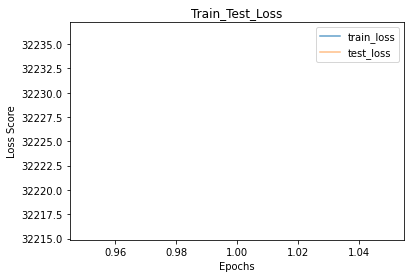

2
Train Epoch: 2 [0/7471 (0%)]	Loss: 30385.562500
Train Epoch: 2 [160/7471 (2%)]	Loss: 31063.373047
Train Epoch: 2 [320/7471 (4%)]	Loss: 32074.128906
Train Epoch: 2 [480/7471 (6%)]	Loss: 33394.074219
Train Epoch: 2 [640/7471 (9%)]	Loss: 31367.181641
Train Epoch: 2 [800/7471 (11%)]	Loss: 32189.566406
Train Epoch: 2 [960/7471 (13%)]	Loss: 33205.761719
Train Epoch: 2 [1120/7471 (15%)]	Loss: 32444.488281
Train Epoch: 2 [1280/7471 (17%)]	Loss: 31370.515625
Train Epoch: 2 [1440/7471 (19%)]	Loss: 29844.484375
Train Epoch: 2 [1600/7471 (21%)]	Loss: 33804.570312
Train Epoch: 2 [1760/7471 (24%)]	Loss: 32853.386719
Train Epoch: 2 [1920/7471 (26%)]	Loss: 32129.845703
Train Epoch: 2 [2080/7471 (28%)]	Loss: 32257.021484
Train Epoch: 2 [2240/7471 (30%)]	Loss: 33174.378906
Train Epoch: 2 [2400/7471 (32%)]	Loss: 31775.056641
Train Epoch: 2 [2560/7471 (34%)]	Loss: 33257.265625
Train Epoch: 2 [2720/7471 (36%)]	Loss: 31794.546875
Train Epoch: 2 [2880/7471 (39%)]	Loss: 30573.363281
Train Epoch: 2 [3040/747

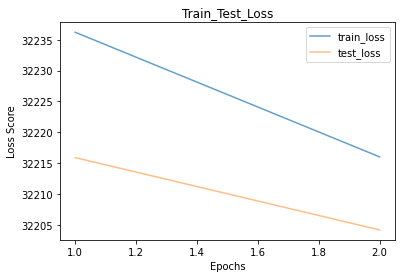

3
Train Epoch: 3 [0/7471 (0%)]	Loss: 30926.402344
Train Epoch: 3 [160/7471 (2%)]	Loss: 31975.753906
Train Epoch: 3 [320/7471 (4%)]	Loss: 32215.470703
Train Epoch: 3 [480/7471 (6%)]	Loss: 31514.701172
Train Epoch: 3 [640/7471 (9%)]	Loss: 32484.490234
Train Epoch: 3 [800/7471 (11%)]	Loss: 33593.246094
Train Epoch: 3 [960/7471 (13%)]	Loss: 29373.089844
Train Epoch: 3 [1120/7471 (15%)]	Loss: 31028.664062
Train Epoch: 3 [1280/7471 (17%)]	Loss: 32884.953125
Train Epoch: 3 [1440/7471 (19%)]	Loss: 33187.019531
Train Epoch: 3 [1600/7471 (21%)]	Loss: 32023.451172
Train Epoch: 3 [1760/7471 (24%)]	Loss: 32150.396484
Train Epoch: 3 [1920/7471 (26%)]	Loss: 31371.751953
Train Epoch: 3 [2080/7471 (28%)]	Loss: 32430.070312
Train Epoch: 3 [2240/7471 (30%)]	Loss: 32432.136719
Train Epoch: 3 [2400/7471 (32%)]	Loss: 32611.427734
Train Epoch: 3 [2560/7471 (34%)]	Loss: 33208.332031
Train Epoch: 3 [2720/7471 (36%)]	Loss: 32428.392578
Train Epoch: 3 [2880/7471 (39%)]	Loss: 33064.179688
Train Epoch: 3 [3040/747

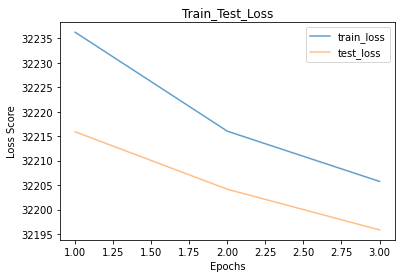

4
Train Epoch: 4 [0/7471 (0%)]	Loss: 32744.181641
Train Epoch: 4 [160/7471 (2%)]	Loss: 31411.052734
Train Epoch: 4 [320/7471 (4%)]	Loss: 32695.656250
Train Epoch: 4 [480/7471 (6%)]	Loss: 32162.703125
Train Epoch: 4 [640/7471 (9%)]	Loss: 33246.304688
Train Epoch: 4 [800/7471 (11%)]	Loss: 32802.855469
Train Epoch: 4 [960/7471 (13%)]	Loss: 32732.841797
Train Epoch: 4 [1120/7471 (15%)]	Loss: 32920.031250
Train Epoch: 4 [1280/7471 (17%)]	Loss: 32385.083984
Train Epoch: 4 [1440/7471 (19%)]	Loss: 32549.804688
Train Epoch: 4 [1600/7471 (21%)]	Loss: 32163.818359
Train Epoch: 4 [1760/7471 (24%)]	Loss: 31603.490234
Train Epoch: 4 [1920/7471 (26%)]	Loss: 31307.607422
Train Epoch: 4 [2080/7471 (28%)]	Loss: 33503.613281
Train Epoch: 4 [2240/7471 (30%)]	Loss: 31730.886719
Train Epoch: 4 [2400/7471 (32%)]	Loss: 31974.103516
Train Epoch: 4 [2560/7471 (34%)]	Loss: 32315.156250
Train Epoch: 4 [2720/7471 (36%)]	Loss: 33027.621094
Train Epoch: 4 [2880/7471 (39%)]	Loss: 33256.757812
Train Epoch: 4 [3040/747

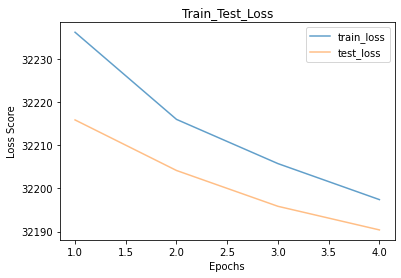

5
Train Epoch: 5 [0/7471 (0%)]	Loss: 31757.529297
Train Epoch: 5 [160/7471 (2%)]	Loss: 31279.845703
Train Epoch: 5 [320/7471 (4%)]	Loss: 32780.960938
Train Epoch: 5 [480/7471 (6%)]	Loss: 31399.970703
Train Epoch: 5 [640/7471 (9%)]	Loss: 31569.080078
Train Epoch: 5 [800/7471 (11%)]	Loss: 32043.199219
Train Epoch: 5 [960/7471 (13%)]	Loss: 32080.767578
Train Epoch: 5 [1120/7471 (15%)]	Loss: 31604.669922
Train Epoch: 5 [1280/7471 (17%)]	Loss: 32703.308594
Train Epoch: 5 [1440/7471 (19%)]	Loss: 31044.818359
Train Epoch: 5 [1600/7471 (21%)]	Loss: 29582.167969
Train Epoch: 5 [1760/7471 (24%)]	Loss: 33308.679688
Train Epoch: 5 [1920/7471 (26%)]	Loss: 32497.535156
Train Epoch: 5 [2080/7471 (28%)]	Loss: 31441.722656
Train Epoch: 5 [2240/7471 (30%)]	Loss: 33452.015625
Train Epoch: 5 [2400/7471 (32%)]	Loss: 30355.839844
Train Epoch: 5 [2560/7471 (34%)]	Loss: 32648.259766
Train Epoch: 5 [2720/7471 (36%)]	Loss: 31254.705078
Train Epoch: 5 [2880/7471 (39%)]	Loss: 32799.242188
Train Epoch: 5 [3040/747

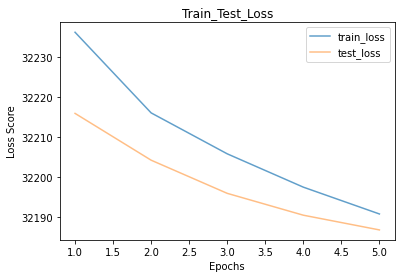

6
Train Epoch: 6 [0/7471 (0%)]	Loss: 32709.949219
Train Epoch: 6 [160/7471 (2%)]	Loss: 31776.101562
Train Epoch: 6 [320/7471 (4%)]	Loss: 32460.904297
Train Epoch: 6 [480/7471 (6%)]	Loss: 33261.957031
Train Epoch: 6 [640/7471 (9%)]	Loss: 32121.238281
Train Epoch: 6 [800/7471 (11%)]	Loss: 31538.613281
Train Epoch: 6 [960/7471 (13%)]	Loss: 32850.015625
Train Epoch: 6 [1120/7471 (15%)]	Loss: 32733.416016
Train Epoch: 6 [1280/7471 (17%)]	Loss: 32600.539062
Train Epoch: 6 [1440/7471 (19%)]	Loss: 31639.089844
Train Epoch: 6 [1600/7471 (21%)]	Loss: 31526.267578
Train Epoch: 6 [1760/7471 (24%)]	Loss: 33098.824219
Train Epoch: 6 [1920/7471 (26%)]	Loss: 31794.785156
Train Epoch: 6 [2080/7471 (28%)]	Loss: 31545.521484
Train Epoch: 6 [2240/7471 (30%)]	Loss: 31742.029297
Train Epoch: 6 [2400/7471 (32%)]	Loss: 30048.179688
Train Epoch: 6 [2560/7471 (34%)]	Loss: 32468.810547
Train Epoch: 6 [2720/7471 (36%)]	Loss: 30982.126953
Train Epoch: 6 [2880/7471 (39%)]	Loss: 32336.031250
Train Epoch: 6 [3040/747

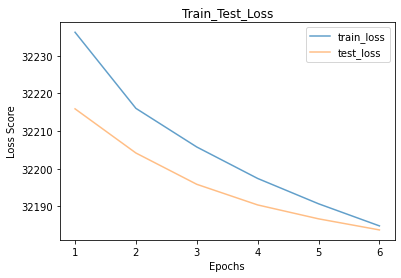

7
Train Epoch: 7 [0/7471 (0%)]	Loss: 30090.314453
Train Epoch: 7 [160/7471 (2%)]	Loss: 31451.607422
Train Epoch: 7 [320/7471 (4%)]	Loss: 32102.292969
Train Epoch: 7 [480/7471 (6%)]	Loss: 32780.882812
Train Epoch: 7 [640/7471 (9%)]	Loss: 31696.523438
Train Epoch: 7 [800/7471 (11%)]	Loss: 31410.992188
Train Epoch: 7 [960/7471 (13%)]	Loss: 31954.330078
Train Epoch: 7 [1120/7471 (15%)]	Loss: 33166.585938
Train Epoch: 7 [1280/7471 (17%)]	Loss: 31786.521484
Train Epoch: 7 [1440/7471 (19%)]	Loss: 32526.699219
Train Epoch: 7 [1600/7471 (21%)]	Loss: 30445.851562
Train Epoch: 7 [1760/7471 (24%)]	Loss: 32717.597656
Train Epoch: 7 [1920/7471 (26%)]	Loss: 30694.298828
Train Epoch: 7 [2080/7471 (28%)]	Loss: 32420.992188
Train Epoch: 7 [2240/7471 (30%)]	Loss: 32478.828125
Train Epoch: 7 [2400/7471 (32%)]	Loss: 32946.398438
Train Epoch: 7 [2560/7471 (34%)]	Loss: 31461.998047
Train Epoch: 7 [2720/7471 (36%)]	Loss: 33625.296875
Train Epoch: 7 [2880/7471 (39%)]	Loss: 32401.759766
Train Epoch: 7 [3040/747

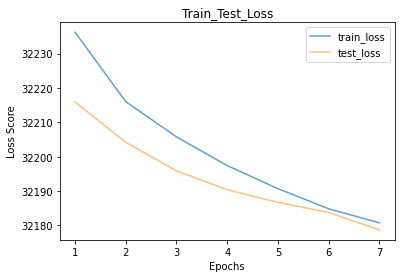

8
Train Epoch: 8 [0/7471 (0%)]	Loss: 33475.335938
Train Epoch: 8 [160/7471 (2%)]	Loss: 31982.820312
Train Epoch: 8 [320/7471 (4%)]	Loss: 32475.757812
Train Epoch: 8 [480/7471 (6%)]	Loss: 29995.255859
Train Epoch: 8 [640/7471 (9%)]	Loss: 31796.462891
Train Epoch: 8 [800/7471 (11%)]	Loss: 32863.828125
Train Epoch: 8 [960/7471 (13%)]	Loss: 32882.160156
Train Epoch: 8 [1120/7471 (15%)]	Loss: 32676.332031
Train Epoch: 8 [1280/7471 (17%)]	Loss: 31784.408203
Train Epoch: 8 [1440/7471 (19%)]	Loss: 33638.601562
Train Epoch: 8 [1600/7471 (21%)]	Loss: 33586.628906
Train Epoch: 8 [1760/7471 (24%)]	Loss: 31358.146484
Train Epoch: 8 [1920/7471 (26%)]	Loss: 32565.062500
Train Epoch: 8 [2080/7471 (28%)]	Loss: 33196.386719
Train Epoch: 8 [2240/7471 (30%)]	Loss: 32241.373047
Train Epoch: 8 [2400/7471 (32%)]	Loss: 32892.683594
Train Epoch: 8 [2560/7471 (34%)]	Loss: 32062.564453
Train Epoch: 8 [2720/7471 (36%)]	Loss: 32769.234375
Train Epoch: 8 [2880/7471 (39%)]	Loss: 33272.636719
Train Epoch: 8 [3040/747

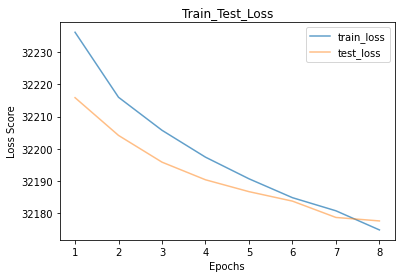

9
Train Epoch: 9 [0/7471 (0%)]	Loss: 29997.687500
Train Epoch: 9 [160/7471 (2%)]	Loss: 32869.902344
Train Epoch: 9 [320/7471 (4%)]	Loss: 31156.365234
Train Epoch: 9 [480/7471 (6%)]	Loss: 31547.126953
Train Epoch: 9 [640/7471 (9%)]	Loss: 32761.996094
Train Epoch: 9 [800/7471 (11%)]	Loss: 32381.857422
Train Epoch: 9 [960/7471 (13%)]	Loss: 33262.421875
Train Epoch: 9 [1120/7471 (15%)]	Loss: 31596.265625
Train Epoch: 9 [1280/7471 (17%)]	Loss: 31990.281250
Train Epoch: 9 [1440/7471 (19%)]	Loss: 33649.527344
Train Epoch: 9 [1600/7471 (21%)]	Loss: 29453.281250
Train Epoch: 9 [1760/7471 (24%)]	Loss: 32677.166016
Train Epoch: 9 [1920/7471 (26%)]	Loss: 32203.992188
Train Epoch: 9 [2080/7471 (28%)]	Loss: 31196.619141
Train Epoch: 9 [2240/7471 (30%)]	Loss: 29613.554688
Train Epoch: 9 [2400/7471 (32%)]	Loss: 32669.685547
Train Epoch: 9 [2560/7471 (34%)]	Loss: 30452.164062
Train Epoch: 9 [2720/7471 (36%)]	Loss: 31242.947266
Train Epoch: 9 [2880/7471 (39%)]	Loss: 33245.269531
Train Epoch: 9 [3040/747

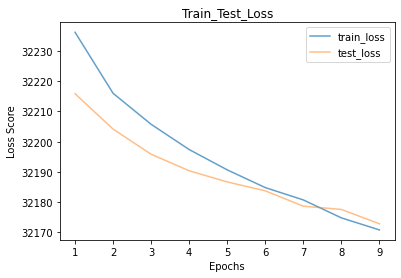

10
Train Epoch: 10 [0/7471 (0%)]	Loss: 32890.214844
Train Epoch: 10 [160/7471 (2%)]	Loss: 31249.425781
Train Epoch: 10 [320/7471 (4%)]	Loss: 31593.011719
Train Epoch: 10 [480/7471 (6%)]	Loss: 33275.496094
Train Epoch: 10 [640/7471 (9%)]	Loss: 32264.689453
Train Epoch: 10 [800/7471 (11%)]	Loss: 32692.677734
Train Epoch: 10 [960/7471 (13%)]	Loss: 32625.937500
Train Epoch: 10 [1120/7471 (15%)]	Loss: 33203.417969
Train Epoch: 10 [1280/7471 (17%)]	Loss: 30806.136719
Train Epoch: 10 [1440/7471 (19%)]	Loss: 33367.027344
Train Epoch: 10 [1600/7471 (21%)]	Loss: 30677.111328
Train Epoch: 10 [1760/7471 (24%)]	Loss: 32493.917969
Train Epoch: 10 [1920/7471 (26%)]	Loss: 33223.691406
Train Epoch: 10 [2080/7471 (28%)]	Loss: 31214.095703
Train Epoch: 10 [2240/7471 (30%)]	Loss: 32994.871094
Train Epoch: 10 [2400/7471 (32%)]	Loss: 32129.587891
Train Epoch: 10 [2560/7471 (34%)]	Loss: 31730.275391
Train Epoch: 10 [2720/7471 (36%)]	Loss: 33005.886719
Train Epoch: 10 [2880/7471 (39%)]	Loss: 32476.966797
Trai

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


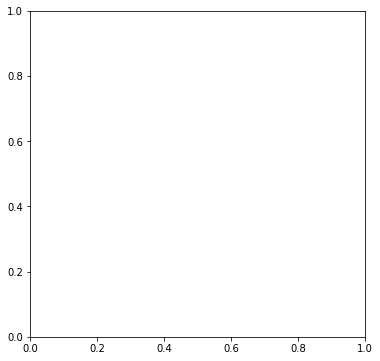

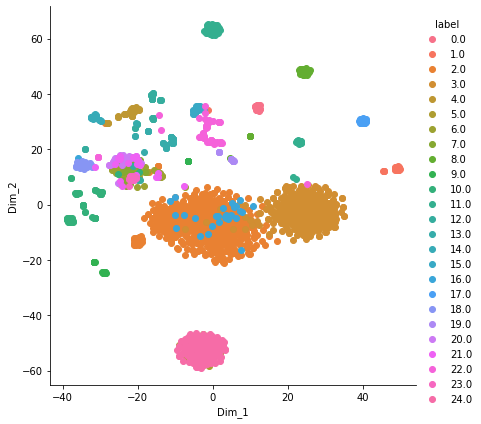

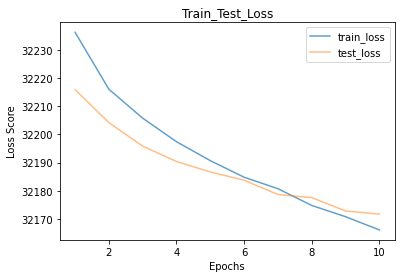

11
Train Epoch: 11 [0/7471 (0%)]	Loss: 31473.697266
Train Epoch: 11 [160/7471 (2%)]	Loss: 32229.230469
Train Epoch: 11 [320/7471 (4%)]	Loss: 33219.046875
Train Epoch: 11 [480/7471 (6%)]	Loss: 31733.134766
Train Epoch: 11 [640/7471 (9%)]	Loss: 33128.683594
Train Epoch: 11 [800/7471 (11%)]	Loss: 31289.671875
Train Epoch: 11 [960/7471 (13%)]	Loss: 32839.820312
Train Epoch: 11 [1120/7471 (15%)]	Loss: 31127.191406
Train Epoch: 11 [1280/7471 (17%)]	Loss: 32577.425781
Train Epoch: 11 [1440/7471 (19%)]	Loss: 32656.824219
Train Epoch: 11 [1600/7471 (21%)]	Loss: 33003.902344
Train Epoch: 11 [1760/7471 (24%)]	Loss: 32950.593750
Train Epoch: 11 [1920/7471 (26%)]	Loss: 33146.835938
Train Epoch: 11 [2080/7471 (28%)]	Loss: 32944.703125
Train Epoch: 11 [2240/7471 (30%)]	Loss: 31306.173828
Train Epoch: 11 [2400/7471 (32%)]	Loss: 32276.341797
Train Epoch: 11 [2560/7471 (34%)]	Loss: 32295.025391
Train Epoch: 11 [2720/7471 (36%)]	Loss: 32995.972656
Train Epoch: 11 [2880/7471 (39%)]	Loss: 30191.146484
Trai

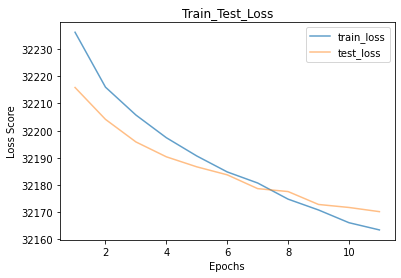

12
Train Epoch: 12 [0/7471 (0%)]	Loss: 32838.109375
Train Epoch: 12 [160/7471 (2%)]	Loss: 33357.218750
Train Epoch: 12 [320/7471 (4%)]	Loss: 33046.066406
Train Epoch: 12 [480/7471 (6%)]	Loss: 33176.046875
Train Epoch: 12 [640/7471 (9%)]	Loss: 32376.148438
Train Epoch: 12 [800/7471 (11%)]	Loss: 33413.925781
Train Epoch: 12 [960/7471 (13%)]	Loss: 32221.787109
Train Epoch: 12 [1120/7471 (15%)]	Loss: 31494.908203
Train Epoch: 12 [1280/7471 (17%)]	Loss: 31452.123047
Train Epoch: 12 [1440/7471 (19%)]	Loss: 31883.033203
Train Epoch: 12 [1600/7471 (21%)]	Loss: 32115.181641
Train Epoch: 12 [1760/7471 (24%)]	Loss: 32808.367188
Train Epoch: 12 [1920/7471 (26%)]	Loss: 30882.363281
Train Epoch: 12 [2080/7471 (28%)]	Loss: 32594.480469
Train Epoch: 12 [2240/7471 (30%)]	Loss: 31323.638672
Train Epoch: 12 [2400/7471 (32%)]	Loss: 33221.371094
Train Epoch: 12 [2560/7471 (34%)]	Loss: 32296.939453
Train Epoch: 12 [2720/7471 (36%)]	Loss: 32332.130859
Train Epoch: 12 [2880/7471 (39%)]	Loss: 32276.298828
Trai

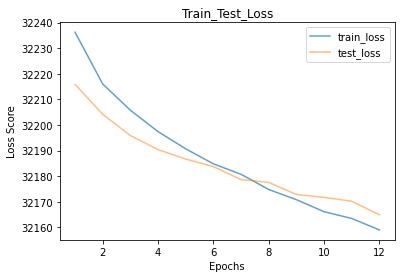

13
Train Epoch: 13 [0/7471 (0%)]	Loss: 32226.660156
Train Epoch: 13 [160/7471 (2%)]	Loss: 33852.878906
Train Epoch: 13 [320/7471 (4%)]	Loss: 30418.099609
Train Epoch: 13 [480/7471 (6%)]	Loss: 33850.039062
Train Epoch: 13 [640/7471 (9%)]	Loss: 33329.625000
Train Epoch: 13 [800/7471 (11%)]	Loss: 32438.671875
Train Epoch: 13 [960/7471 (13%)]	Loss: 33627.503906
Train Epoch: 13 [1120/7471 (15%)]	Loss: 31010.121094
Train Epoch: 13 [1280/7471 (17%)]	Loss: 31543.759766
Train Epoch: 13 [1440/7471 (19%)]	Loss: 33024.949219
Train Epoch: 13 [1600/7471 (21%)]	Loss: 31978.304688
Train Epoch: 13 [1760/7471 (24%)]	Loss: 33342.996094
Train Epoch: 13 [1920/7471 (26%)]	Loss: 32119.544922
Train Epoch: 13 [2080/7471 (28%)]	Loss: 30651.226562
Train Epoch: 13 [2240/7471 (30%)]	Loss: 32708.123047
Train Epoch: 13 [2400/7471 (32%)]	Loss: 33035.488281
Train Epoch: 13 [2560/7471 (34%)]	Loss: 33530.175781
Train Epoch: 13 [2720/7471 (36%)]	Loss: 30411.273438
Train Epoch: 13 [2880/7471 (39%)]	Loss: 32758.537109
Trai

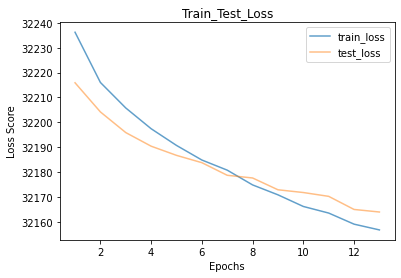

14
Train Epoch: 14 [0/7471 (0%)]	Loss: 32123.242188
Train Epoch: 14 [160/7471 (2%)]	Loss: 33068.859375
Train Epoch: 14 [320/7471 (4%)]	Loss: 32240.662109
Train Epoch: 14 [480/7471 (6%)]	Loss: 32296.265625
Train Epoch: 14 [640/7471 (9%)]	Loss: 32327.187500
Train Epoch: 14 [800/7471 (11%)]	Loss: 32899.500000
Train Epoch: 14 [960/7471 (13%)]	Loss: 32105.783203
Train Epoch: 14 [1120/7471 (15%)]	Loss: 32337.591797
Train Epoch: 14 [1280/7471 (17%)]	Loss: 32493.544922
Train Epoch: 14 [1440/7471 (19%)]	Loss: 31760.308594
Train Epoch: 14 [1600/7471 (21%)]	Loss: 31318.468750
Train Epoch: 14 [1760/7471 (24%)]	Loss: 33069.515625
Train Epoch: 14 [1920/7471 (26%)]	Loss: 32204.408203
Train Epoch: 14 [2080/7471 (28%)]	Loss: 33091.296875
Train Epoch: 14 [2240/7471 (30%)]	Loss: 32293.402344
Train Epoch: 14 [2400/7471 (32%)]	Loss: 32903.914062
Train Epoch: 14 [2560/7471 (34%)]	Loss: 33312.636719
Train Epoch: 14 [2720/7471 (36%)]	Loss: 32413.187500
Train Epoch: 14 [2880/7471 (39%)]	Loss: 33055.175781
Trai

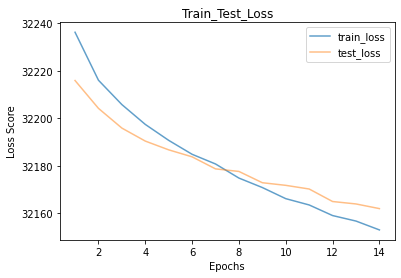

15
Train Epoch: 15 [0/7471 (0%)]	Loss: 30443.019531
Train Epoch: 15 [160/7471 (2%)]	Loss: 32353.126953
Train Epoch: 15 [320/7471 (4%)]	Loss: 32501.437500
Train Epoch: 15 [480/7471 (6%)]	Loss: 31753.777344
Train Epoch: 15 [640/7471 (9%)]	Loss: 32624.798828
Train Epoch: 15 [800/7471 (11%)]	Loss: 33448.328125
Train Epoch: 15 [960/7471 (13%)]	Loss: 31955.345703
Train Epoch: 15 [1120/7471 (15%)]	Loss: 32931.128906
Train Epoch: 15 [1280/7471 (17%)]	Loss: 32628.960938
Train Epoch: 15 [1440/7471 (19%)]	Loss: 32005.800781
Train Epoch: 15 [1600/7471 (21%)]	Loss: 31515.003906
Train Epoch: 15 [1760/7471 (24%)]	Loss: 30489.144531
Train Epoch: 15 [1920/7471 (26%)]	Loss: 31537.035156
Train Epoch: 15 [2080/7471 (28%)]	Loss: 31579.791016
Train Epoch: 15 [2240/7471 (30%)]	Loss: 33204.566406
Train Epoch: 15 [2400/7471 (32%)]	Loss: 32364.761719
Train Epoch: 15 [2560/7471 (34%)]	Loss: 31478.210938
Train Epoch: 15 [2720/7471 (36%)]	Loss: 33383.242188
Train Epoch: 15 [2880/7471 (39%)]	Loss: 32014.511719
Trai

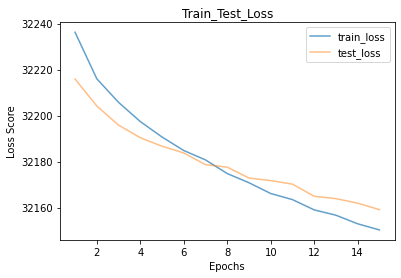

16
Train Epoch: 16 [0/7471 (0%)]	Loss: 33089.503906
Train Epoch: 16 [160/7471 (2%)]	Loss: 31949.888672
Train Epoch: 16 [320/7471 (4%)]	Loss: 31069.703125
Train Epoch: 16 [480/7471 (6%)]	Loss: 32622.892578
Train Epoch: 16 [640/7471 (9%)]	Loss: 32881.886719
Train Epoch: 16 [800/7471 (11%)]	Loss: 33281.894531
Train Epoch: 16 [960/7471 (13%)]	Loss: 32238.363281
Train Epoch: 16 [1120/7471 (15%)]	Loss: 32949.343750
Train Epoch: 16 [1280/7471 (17%)]	Loss: 31004.435547
Train Epoch: 16 [1440/7471 (19%)]	Loss: 33322.156250
Train Epoch: 16 [1600/7471 (21%)]	Loss: 33243.691406
Train Epoch: 16 [1760/7471 (24%)]	Loss: 33816.253906
Train Epoch: 16 [1920/7471 (26%)]	Loss: 30994.187500
Train Epoch: 16 [2080/7471 (28%)]	Loss: 32524.660156
Train Epoch: 16 [2240/7471 (30%)]	Loss: 31686.595703
Train Epoch: 16 [2400/7471 (32%)]	Loss: 33397.949219
Train Epoch: 16 [2560/7471 (34%)]	Loss: 31328.898438
Train Epoch: 16 [2720/7471 (36%)]	Loss: 31859.291016
Train Epoch: 16 [2880/7471 (39%)]	Loss: 33392.722656
Trai

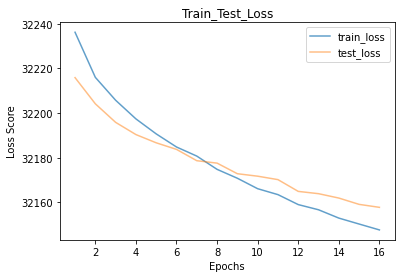

17
Train Epoch: 17 [0/7471 (0%)]	Loss: 31120.943359
Train Epoch: 17 [160/7471 (2%)]	Loss: 33125.789062
Train Epoch: 17 [320/7471 (4%)]	Loss: 32815.105469
Train Epoch: 17 [480/7471 (6%)]	Loss: 31682.630859
Train Epoch: 17 [640/7471 (9%)]	Loss: 32834.648438
Train Epoch: 17 [800/7471 (11%)]	Loss: 32245.429688
Train Epoch: 17 [960/7471 (13%)]	Loss: 32711.005859
Train Epoch: 17 [1120/7471 (15%)]	Loss: 32342.431641
Train Epoch: 17 [1280/7471 (17%)]	Loss: 32438.113281
Train Epoch: 17 [1440/7471 (19%)]	Loss: 32242.730469
Train Epoch: 17 [1600/7471 (21%)]	Loss: 32834.503906
Train Epoch: 17 [1760/7471 (24%)]	Loss: 32146.494141
Train Epoch: 17 [1920/7471 (26%)]	Loss: 31787.476562
Train Epoch: 17 [2080/7471 (28%)]	Loss: 30994.328125
Train Epoch: 17 [2240/7471 (30%)]	Loss: 31497.667969
Train Epoch: 17 [2400/7471 (32%)]	Loss: 32334.693359
Train Epoch: 17 [2560/7471 (34%)]	Loss: 32712.435547
Train Epoch: 17 [2720/7471 (36%)]	Loss: 32144.000000
Train Epoch: 17 [2880/7471 (39%)]	Loss: 32691.552734
Trai

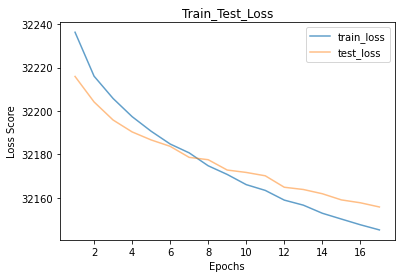

18
Train Epoch: 18 [0/7471 (0%)]	Loss: 33019.414062
Train Epoch: 18 [160/7471 (2%)]	Loss: 32845.722656
Train Epoch: 18 [320/7471 (4%)]	Loss: 31906.458984
Train Epoch: 18 [480/7471 (6%)]	Loss: 31279.802734
Train Epoch: 18 [640/7471 (9%)]	Loss: 33247.710938
Train Epoch: 18 [800/7471 (11%)]	Loss: 32588.015625
Train Epoch: 18 [960/7471 (13%)]	Loss: 32098.259766
Train Epoch: 18 [1120/7471 (15%)]	Loss: 32751.601562
Train Epoch: 18 [1280/7471 (17%)]	Loss: 32166.216797
Train Epoch: 18 [1440/7471 (19%)]	Loss: 32062.753906
Train Epoch: 18 [1600/7471 (21%)]	Loss: 32002.271484
Train Epoch: 18 [1760/7471 (24%)]	Loss: 32589.335938
Train Epoch: 18 [1920/7471 (26%)]	Loss: 31067.126953
Train Epoch: 18 [2080/7471 (28%)]	Loss: 31381.259766
Train Epoch: 18 [2240/7471 (30%)]	Loss: 32532.181641
Train Epoch: 18 [2400/7471 (32%)]	Loss: 32151.482422
Train Epoch: 18 [2560/7471 (34%)]	Loss: 32717.447266
Train Epoch: 18 [2720/7471 (36%)]	Loss: 32041.861328
Train Epoch: 18 [2880/7471 (39%)]	Loss: 32131.177734
Trai

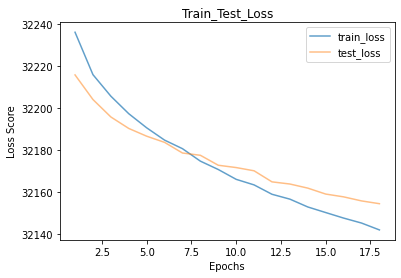

19
Train Epoch: 19 [0/7471 (0%)]	Loss: 31588.800781
Train Epoch: 19 [160/7471 (2%)]	Loss: 31905.494141
Train Epoch: 19 [320/7471 (4%)]	Loss: 32585.376953
Train Epoch: 19 [480/7471 (6%)]	Loss: 32198.171875
Train Epoch: 19 [640/7471 (9%)]	Loss: 32017.402344
Train Epoch: 19 [800/7471 (11%)]	Loss: 31684.287109
Train Epoch: 19 [960/7471 (13%)]	Loss: 33399.320312
Train Epoch: 19 [1120/7471 (15%)]	Loss: 32381.611328
Train Epoch: 19 [1280/7471 (17%)]	Loss: 33065.484375
Train Epoch: 19 [1440/7471 (19%)]	Loss: 31902.892578
Train Epoch: 19 [1600/7471 (21%)]	Loss: 32489.626953
Train Epoch: 19 [1760/7471 (24%)]	Loss: 31596.089844
Train Epoch: 19 [1920/7471 (26%)]	Loss: 31521.087891
Train Epoch: 19 [2080/7471 (28%)]	Loss: 29508.599609
Train Epoch: 19 [2240/7471 (30%)]	Loss: 31446.693359
Train Epoch: 19 [2400/7471 (32%)]	Loss: 31933.509766
Train Epoch: 19 [2560/7471 (34%)]	Loss: 30615.046875
Train Epoch: 19 [2720/7471 (36%)]	Loss: 31581.472656
Train Epoch: 19 [2880/7471 (39%)]	Loss: 30482.787109
Trai

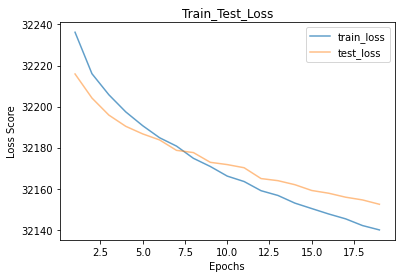

20
Train Epoch: 20 [0/7471 (0%)]	Loss: 33238.242188
Train Epoch: 20 [160/7471 (2%)]	Loss: 33019.765625
Train Epoch: 20 [320/7471 (4%)]	Loss: 32469.271484
Train Epoch: 20 [480/7471 (6%)]	Loss: 33737.039062
Train Epoch: 20 [640/7471 (9%)]	Loss: 32148.453125
Train Epoch: 20 [800/7471 (11%)]	Loss: 31927.259766
Train Epoch: 20 [960/7471 (13%)]	Loss: 32004.541016
Train Epoch: 20 [1120/7471 (15%)]	Loss: 32467.181641
Train Epoch: 20 [1280/7471 (17%)]	Loss: 31062.632812
Train Epoch: 20 [1440/7471 (19%)]	Loss: 33116.855469
Train Epoch: 20 [1600/7471 (21%)]	Loss: 33063.066406
Train Epoch: 20 [1760/7471 (24%)]	Loss: 31251.449219
Train Epoch: 20 [1920/7471 (26%)]	Loss: 32712.568359
Train Epoch: 20 [2080/7471 (28%)]	Loss: 33123.781250
Train Epoch: 20 [2240/7471 (30%)]	Loss: 31621.242188
Train Epoch: 20 [2400/7471 (32%)]	Loss: 32454.392578
Train Epoch: 20 [2560/7471 (34%)]	Loss: 31964.734375
Train Epoch: 20 [2720/7471 (36%)]	Loss: 33130.878906
Train Epoch: 20 [2880/7471 (39%)]	Loss: 32165.265625
Trai

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


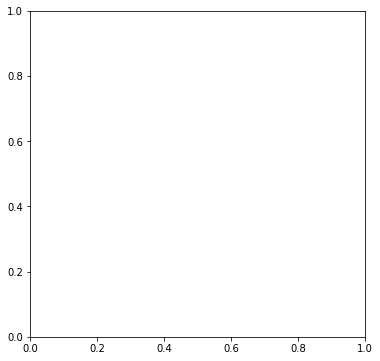

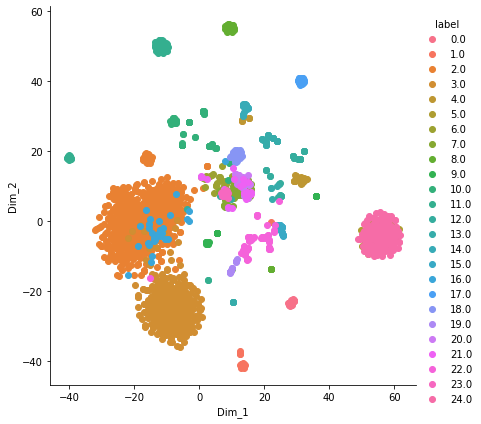

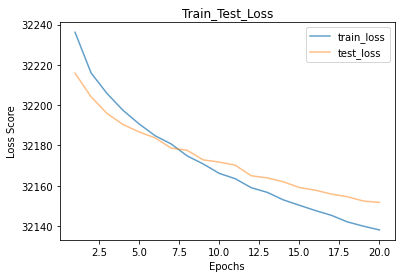

21
Train Epoch: 21 [0/7471 (0%)]	Loss: 31669.552734
Train Epoch: 21 [160/7471 (2%)]	Loss: 32466.353516
Train Epoch: 21 [320/7471 (4%)]	Loss: 31873.101562
Train Epoch: 21 [480/7471 (6%)]	Loss: 31276.027344
Train Epoch: 21 [640/7471 (9%)]	Loss: 32932.035156
Train Epoch: 21 [800/7471 (11%)]	Loss: 32045.632812
Train Epoch: 21 [960/7471 (13%)]	Loss: 30575.267578
Train Epoch: 21 [1120/7471 (15%)]	Loss: 31362.816406
Train Epoch: 21 [1280/7471 (17%)]	Loss: 32089.470703
Train Epoch: 21 [1440/7471 (19%)]	Loss: 30701.099609
Train Epoch: 21 [1600/7471 (21%)]	Loss: 32675.964844
Train Epoch: 21 [1760/7471 (24%)]	Loss: 31491.687500
Train Epoch: 21 [1920/7471 (26%)]	Loss: 31841.802734
Train Epoch: 21 [2080/7471 (28%)]	Loss: 32703.250000
Train Epoch: 21 [2240/7471 (30%)]	Loss: 32464.642578
Train Epoch: 21 [2400/7471 (32%)]	Loss: 33728.609375
Train Epoch: 21 [2560/7471 (34%)]	Loss: 31697.177734
Train Epoch: 21 [2720/7471 (36%)]	Loss: 33085.039062
Train Epoch: 21 [2880/7471 (39%)]	Loss: 32408.248047
Trai

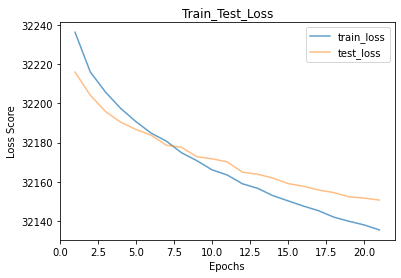

22
Train Epoch: 22 [0/7471 (0%)]	Loss: 32598.447266
Train Epoch: 22 [160/7471 (2%)]	Loss: 31659.626953
Train Epoch: 22 [320/7471 (4%)]	Loss: 30545.957031
Train Epoch: 22 [480/7471 (6%)]	Loss: 32892.121094
Train Epoch: 22 [640/7471 (9%)]	Loss: 32640.345703
Train Epoch: 22 [800/7471 (11%)]	Loss: 31723.437500
Train Epoch: 22 [960/7471 (13%)]	Loss: 33254.781250
Train Epoch: 22 [1120/7471 (15%)]	Loss: 32009.599609
Train Epoch: 22 [1280/7471 (17%)]	Loss: 32202.851562
Train Epoch: 22 [1440/7471 (19%)]	Loss: 32925.546875
Train Epoch: 22 [1600/7471 (21%)]	Loss: 30843.537109
Train Epoch: 22 [1760/7471 (24%)]	Loss: 30737.074219
Train Epoch: 22 [1920/7471 (26%)]	Loss: 33216.968750
Train Epoch: 22 [2080/7471 (28%)]	Loss: 32947.945312
Train Epoch: 22 [2240/7471 (30%)]	Loss: 32762.662109
Train Epoch: 22 [2400/7471 (32%)]	Loss: 29937.724609
Train Epoch: 22 [2560/7471 (34%)]	Loss: 33402.246094
Train Epoch: 22 [2720/7471 (36%)]	Loss: 32782.726562
Train Epoch: 22 [2880/7471 (39%)]	Loss: 31639.453125
Trai

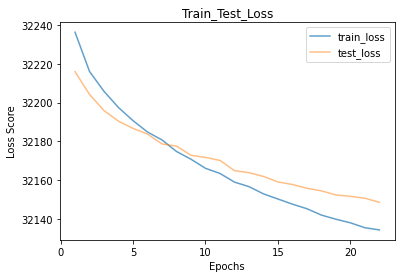

23
Train Epoch: 23 [0/7471 (0%)]	Loss: 33046.605469
Train Epoch: 23 [160/7471 (2%)]	Loss: 30542.728516
Train Epoch: 23 [320/7471 (4%)]	Loss: 31621.412109
Train Epoch: 23 [480/7471 (6%)]	Loss: 32755.779297
Train Epoch: 23 [640/7471 (9%)]	Loss: 33648.003906
Train Epoch: 23 [800/7471 (11%)]	Loss: 33367.347656
Train Epoch: 23 [960/7471 (13%)]	Loss: 31946.128906
Train Epoch: 23 [1120/7471 (15%)]	Loss: 31254.794922
Train Epoch: 23 [1280/7471 (17%)]	Loss: 31219.175781
Train Epoch: 23 [1440/7471 (19%)]	Loss: 30864.667969
Train Epoch: 23 [1600/7471 (21%)]	Loss: 32331.769531
Train Epoch: 23 [1760/7471 (24%)]	Loss: 32674.876953
Train Epoch: 23 [1920/7471 (26%)]	Loss: 30940.562500
Train Epoch: 23 [2080/7471 (28%)]	Loss: 31674.996094
Train Epoch: 23 [2240/7471 (30%)]	Loss: 31631.660156
Train Epoch: 23 [2400/7471 (32%)]	Loss: 33294.511719
Train Epoch: 23 [2560/7471 (34%)]	Loss: 33200.648438
Train Epoch: 23 [2720/7471 (36%)]	Loss: 30579.136719
Train Epoch: 23 [2880/7471 (39%)]	Loss: 32100.814453
Trai

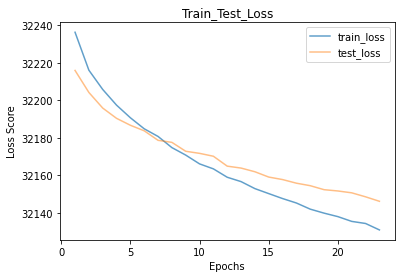

24
Train Epoch: 24 [0/7471 (0%)]	Loss: 33396.269531
Train Epoch: 24 [160/7471 (2%)]	Loss: 32780.777344
Train Epoch: 24 [320/7471 (4%)]	Loss: 31959.423828
Train Epoch: 24 [480/7471 (6%)]	Loss: 32710.837891
Train Epoch: 24 [640/7471 (9%)]	Loss: 32986.382812
Train Epoch: 24 [800/7471 (11%)]	Loss: 30518.238281
Train Epoch: 24 [960/7471 (13%)]	Loss: 32774.062500
Train Epoch: 24 [1120/7471 (15%)]	Loss: 32796.714844
Train Epoch: 24 [1280/7471 (17%)]	Loss: 33607.578125
Train Epoch: 24 [1440/7471 (19%)]	Loss: 31987.615234
Train Epoch: 24 [1600/7471 (21%)]	Loss: 33391.132812
Train Epoch: 24 [1760/7471 (24%)]	Loss: 32468.582031
Train Epoch: 24 [1920/7471 (26%)]	Loss: 32032.183594
Train Epoch: 24 [2080/7471 (28%)]	Loss: 30674.013672
Train Epoch: 24 [2240/7471 (30%)]	Loss: 33432.476562
Train Epoch: 24 [2400/7471 (32%)]	Loss: 31359.517578
Train Epoch: 24 [2560/7471 (34%)]	Loss: 31361.273438
Train Epoch: 24 [2720/7471 (36%)]	Loss: 33130.152344
Train Epoch: 24 [2880/7471 (39%)]	Loss: 31099.031250
Trai

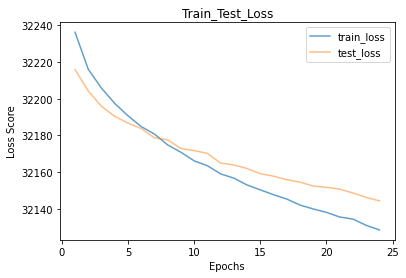

25
Train Epoch: 25 [0/7471 (0%)]	Loss: 32338.212891
Train Epoch: 25 [160/7471 (2%)]	Loss: 32637.595703
Train Epoch: 25 [320/7471 (4%)]	Loss: 33300.511719
Train Epoch: 25 [480/7471 (6%)]	Loss: 29894.716797
Train Epoch: 25 [640/7471 (9%)]	Loss: 32981.429688
Train Epoch: 25 [800/7471 (11%)]	Loss: 33677.355469
Train Epoch: 25 [960/7471 (13%)]	Loss: 33769.773438
Train Epoch: 25 [1120/7471 (15%)]	Loss: 33045.960938
Train Epoch: 25 [1280/7471 (17%)]	Loss: 33219.160156
Train Epoch: 25 [1440/7471 (19%)]	Loss: 30802.611328
Train Epoch: 25 [1600/7471 (21%)]	Loss: 32991.300781
Train Epoch: 25 [1760/7471 (24%)]	Loss: 31889.490234
Train Epoch: 25 [1920/7471 (26%)]	Loss: 33315.199219
Train Epoch: 25 [2080/7471 (28%)]	Loss: 33440.960938
Train Epoch: 25 [2240/7471 (30%)]	Loss: 29671.660156
Train Epoch: 25 [2400/7471 (32%)]	Loss: 31214.197266
Train Epoch: 25 [2560/7471 (34%)]	Loss: 32919.695312
Train Epoch: 25 [2720/7471 (36%)]	Loss: 32374.144531
Train Epoch: 25 [2880/7471 (39%)]	Loss: 29496.160156
Trai

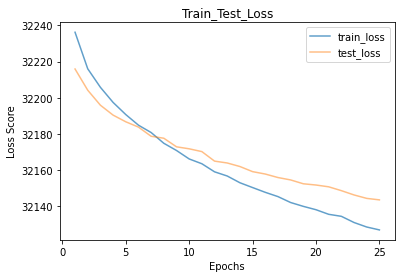

26
Train Epoch: 26 [0/7471 (0%)]	Loss: 31245.578125
Train Epoch: 26 [160/7471 (2%)]	Loss: 32739.568359
Train Epoch: 26 [320/7471 (4%)]	Loss: 32168.367188
Train Epoch: 26 [480/7471 (6%)]	Loss: 32882.585938
Train Epoch: 26 [640/7471 (9%)]	Loss: 31370.490234
Train Epoch: 26 [800/7471 (11%)]	Loss: 31674.224609
Train Epoch: 26 [960/7471 (13%)]	Loss: 32861.546875
Train Epoch: 26 [1120/7471 (15%)]	Loss: 33309.273438
Train Epoch: 26 [1280/7471 (17%)]	Loss: 33219.640625
Train Epoch: 26 [1440/7471 (19%)]	Loss: 32118.248047
Train Epoch: 26 [1600/7471 (21%)]	Loss: 32405.695312
Train Epoch: 26 [1760/7471 (24%)]	Loss: 32134.746094
Train Epoch: 26 [1920/7471 (26%)]	Loss: 31650.404297
Train Epoch: 26 [2080/7471 (28%)]	Loss: 32620.548828
Train Epoch: 26 [2240/7471 (30%)]	Loss: 33360.601562
Train Epoch: 26 [2400/7471 (32%)]	Loss: 30295.583984
Train Epoch: 26 [2560/7471 (34%)]	Loss: 32740.164062
Train Epoch: 26 [2720/7471 (36%)]	Loss: 31853.558594
Train Epoch: 26 [2880/7471 (39%)]	Loss: 31793.929688
Trai

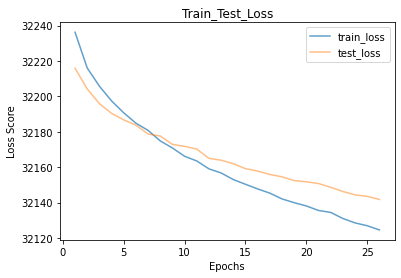

27
Train Epoch: 27 [0/7471 (0%)]	Loss: 32605.691406
Train Epoch: 27 [160/7471 (2%)]	Loss: 30783.396484
Train Epoch: 27 [320/7471 (4%)]	Loss: 31694.818359
Train Epoch: 27 [480/7471 (6%)]	Loss: 32469.244141
Train Epoch: 27 [640/7471 (9%)]	Loss: 32152.498047
Train Epoch: 27 [800/7471 (11%)]	Loss: 31439.074219
Train Epoch: 27 [960/7471 (13%)]	Loss: 33589.910156
Train Epoch: 27 [1120/7471 (15%)]	Loss: 32523.871094
Train Epoch: 27 [1280/7471 (17%)]	Loss: 32492.203125
Train Epoch: 27 [1440/7471 (19%)]	Loss: 32943.316406
Train Epoch: 27 [1600/7471 (21%)]	Loss: 31784.183594
Train Epoch: 27 [1760/7471 (24%)]	Loss: 32732.166016
Train Epoch: 27 [1920/7471 (26%)]	Loss: 33299.964844
Train Epoch: 27 [2080/7471 (28%)]	Loss: 33506.820312
Train Epoch: 27 [2240/7471 (30%)]	Loss: 33109.019531
Train Epoch: 27 [2400/7471 (32%)]	Loss: 32880.593750
Train Epoch: 27 [2560/7471 (34%)]	Loss: 33373.386719
Train Epoch: 27 [2720/7471 (36%)]	Loss: 32509.785156
Train Epoch: 27 [2880/7471 (39%)]	Loss: 32172.300781
Trai

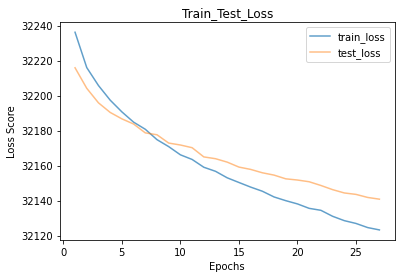

28
Train Epoch: 28 [0/7471 (0%)]	Loss: 32196.835938
Train Epoch: 28 [160/7471 (2%)]	Loss: 31528.289062
Train Epoch: 28 [320/7471 (4%)]	Loss: 33092.003906
Train Epoch: 28 [480/7471 (6%)]	Loss: 31170.277344
Train Epoch: 28 [640/7471 (9%)]	Loss: 32193.406250
Train Epoch: 28 [800/7471 (11%)]	Loss: 33254.335938
Train Epoch: 28 [960/7471 (13%)]	Loss: 33510.402344
Train Epoch: 28 [1120/7471 (15%)]	Loss: 32479.644531
Train Epoch: 28 [1280/7471 (17%)]	Loss: 31874.402344
Train Epoch: 28 [1440/7471 (19%)]	Loss: 32013.984375
Train Epoch: 28 [1600/7471 (21%)]	Loss: 31756.271484
Train Epoch: 28 [1760/7471 (24%)]	Loss: 32017.667969
Train Epoch: 28 [1920/7471 (26%)]	Loss: 30457.746094
Train Epoch: 28 [2080/7471 (28%)]	Loss: 32891.457031
Train Epoch: 28 [2240/7471 (30%)]	Loss: 31094.646484
Train Epoch: 28 [2400/7471 (32%)]	Loss: 31007.123047
Train Epoch: 28 [2560/7471 (34%)]	Loss: 31096.822266
Train Epoch: 28 [2720/7471 (36%)]	Loss: 31440.304688
Train Epoch: 28 [2880/7471 (39%)]	Loss: 32573.792969
Trai

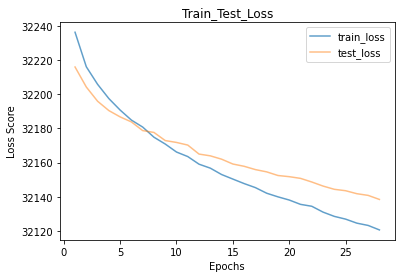

29
Train Epoch: 29 [0/7471 (0%)]	Loss: 33367.207031
Train Epoch: 29 [160/7471 (2%)]	Loss: 32109.902344
Train Epoch: 29 [320/7471 (4%)]	Loss: 30837.142578
Train Epoch: 29 [480/7471 (6%)]	Loss: 32738.689453
Train Epoch: 29 [640/7471 (9%)]	Loss: 33083.093750
Train Epoch: 29 [800/7471 (11%)]	Loss: 31749.833984
Train Epoch: 29 [960/7471 (13%)]	Loss: 33222.644531
Train Epoch: 29 [1120/7471 (15%)]	Loss: 32424.978516
Train Epoch: 29 [1280/7471 (17%)]	Loss: 30686.744141
Train Epoch: 29 [1440/7471 (19%)]	Loss: 32436.886719
Train Epoch: 29 [1600/7471 (21%)]	Loss: 32525.074219
Train Epoch: 29 [1760/7471 (24%)]	Loss: 32658.619141
Train Epoch: 29 [1920/7471 (26%)]	Loss: 31949.857422
Train Epoch: 29 [2080/7471 (28%)]	Loss: 32644.656250
Train Epoch: 29 [2240/7471 (30%)]	Loss: 31015.113281
Train Epoch: 29 [2400/7471 (32%)]	Loss: 32169.337891
Train Epoch: 29 [2560/7471 (34%)]	Loss: 31639.871094
Train Epoch: 29 [2720/7471 (36%)]	Loss: 33367.652344
Train Epoch: 29 [2880/7471 (39%)]	Loss: 32142.644531
Trai

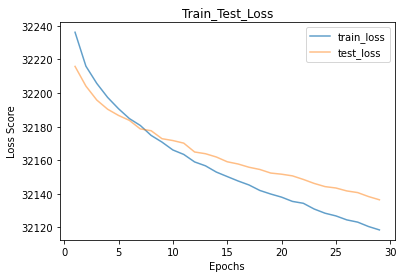

30
Train Epoch: 30 [0/7471 (0%)]	Loss: 31555.953125
Train Epoch: 30 [160/7471 (2%)]	Loss: 32463.683594
Train Epoch: 30 [320/7471 (4%)]	Loss: 32146.763672
Train Epoch: 30 [480/7471 (6%)]	Loss: 31709.425781
Train Epoch: 30 [640/7471 (9%)]	Loss: 31362.234375
Train Epoch: 30 [800/7471 (11%)]	Loss: 31938.908203
Train Epoch: 30 [960/7471 (13%)]	Loss: 32793.210938
Train Epoch: 30 [1120/7471 (15%)]	Loss: 31361.171875
Train Epoch: 30 [1280/7471 (17%)]	Loss: 30828.097656
Train Epoch: 30 [1440/7471 (19%)]	Loss: 33282.628906
Train Epoch: 30 [1600/7471 (21%)]	Loss: 32220.546875
Train Epoch: 30 [1760/7471 (24%)]	Loss: 32550.392578
Train Epoch: 30 [1920/7471 (26%)]	Loss: 31168.824219
Train Epoch: 30 [2080/7471 (28%)]	Loss: 33245.105469
Train Epoch: 30 [2240/7471 (30%)]	Loss: 33424.398438
Train Epoch: 30 [2400/7471 (32%)]	Loss: 29274.214844
Train Epoch: 30 [2560/7471 (34%)]	Loss: 31735.867188
Train Epoch: 30 [2720/7471 (36%)]	Loss: 32908.402344
Train Epoch: 30 [2880/7471 (39%)]	Loss: 29934.197266
Trai

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


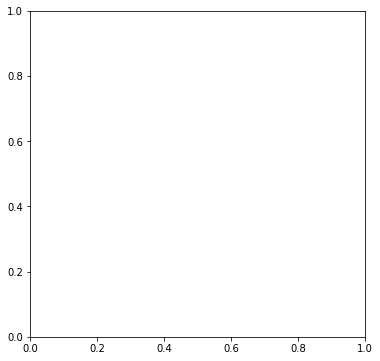

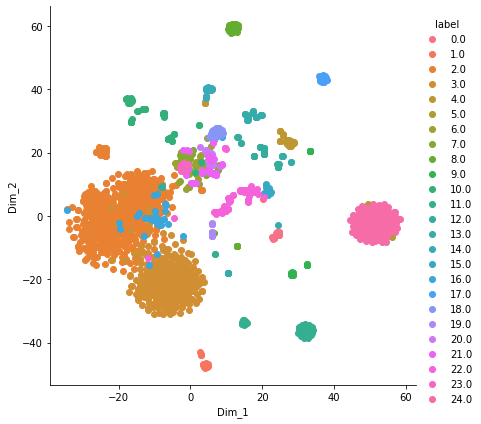

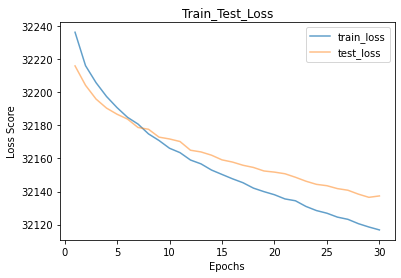

31
Train Epoch: 31 [0/7471 (0%)]	Loss: 32804.425781
Train Epoch: 31 [160/7471 (2%)]	Loss: 32861.492188
Train Epoch: 31 [320/7471 (4%)]	Loss: 32036.792969
Train Epoch: 31 [480/7471 (6%)]	Loss: 33346.953125
Train Epoch: 31 [640/7471 (9%)]	Loss: 31520.294922
Train Epoch: 31 [800/7471 (11%)]	Loss: 31832.349609
Train Epoch: 31 [960/7471 (13%)]	Loss: 32399.488281
Train Epoch: 31 [1120/7471 (15%)]	Loss: 31171.494141
Train Epoch: 31 [1280/7471 (17%)]	Loss: 33404.644531
Train Epoch: 31 [1440/7471 (19%)]	Loss: 30860.937500
Train Epoch: 31 [1600/7471 (21%)]	Loss: 30747.746094
Train Epoch: 31 [1760/7471 (24%)]	Loss: 32347.660156
Train Epoch: 31 [1920/7471 (26%)]	Loss: 32720.203125
Train Epoch: 31 [2080/7471 (28%)]	Loss: 32379.208984
Train Epoch: 31 [2240/7471 (30%)]	Loss: 31653.060547
Train Epoch: 31 [2400/7471 (32%)]	Loss: 32198.238281
Train Epoch: 31 [2560/7471 (34%)]	Loss: 32038.724609
Train Epoch: 31 [2720/7471 (36%)]	Loss: 30710.406250
Train Epoch: 31 [2880/7471 (39%)]	Loss: 33084.585938
Trai

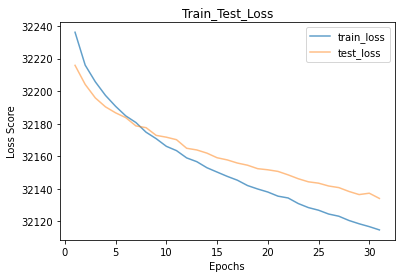

32
Train Epoch: 32 [0/7471 (0%)]	Loss: 32465.734375
Train Epoch: 32 [160/7471 (2%)]	Loss: 31755.097656
Train Epoch: 32 [320/7471 (4%)]	Loss: 31681.222656
Train Epoch: 32 [480/7471 (6%)]	Loss: 31242.259766
Train Epoch: 32 [640/7471 (9%)]	Loss: 30388.759766
Train Epoch: 32 [800/7471 (11%)]	Loss: 32634.347656
Train Epoch: 32 [960/7471 (13%)]	Loss: 31072.021484
Train Epoch: 32 [1120/7471 (15%)]	Loss: 32067.099609
Train Epoch: 32 [1280/7471 (17%)]	Loss: 32068.910156
Train Epoch: 32 [1440/7471 (19%)]	Loss: 33778.214844
Train Epoch: 32 [1600/7471 (21%)]	Loss: 30407.011719
Train Epoch: 32 [1760/7471 (24%)]	Loss: 32825.613281
Train Epoch: 32 [1920/7471 (26%)]	Loss: 32920.070312
Train Epoch: 32 [2080/7471 (28%)]	Loss: 31221.638672
Train Epoch: 32 [2240/7471 (30%)]	Loss: 32134.964844
Train Epoch: 32 [2400/7471 (32%)]	Loss: 31802.726562
Train Epoch: 32 [2560/7471 (34%)]	Loss: 31658.179688
Train Epoch: 32 [2720/7471 (36%)]	Loss: 33177.269531
Train Epoch: 32 [2880/7471 (39%)]	Loss: 29566.742188
Trai

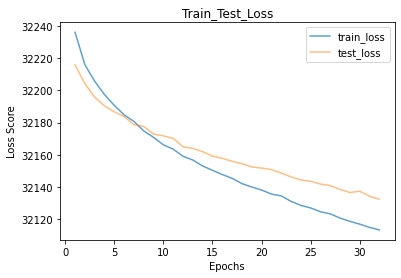

33
Train Epoch: 33 [0/7471 (0%)]	Loss: 31259.919922
Train Epoch: 33 [160/7471 (2%)]	Loss: 31837.628906
Train Epoch: 33 [320/7471 (4%)]	Loss: 32061.880859
Train Epoch: 33 [480/7471 (6%)]	Loss: 31548.841797
Train Epoch: 33 [640/7471 (9%)]	Loss: 31709.072266
Train Epoch: 33 [800/7471 (11%)]	Loss: 32740.955078
Train Epoch: 33 [960/7471 (13%)]	Loss: 33249.605469
Train Epoch: 33 [1120/7471 (15%)]	Loss: 32002.296875
Train Epoch: 33 [1280/7471 (17%)]	Loss: 32040.037109
Train Epoch: 33 [1440/7471 (19%)]	Loss: 32481.164062
Train Epoch: 33 [1600/7471 (21%)]	Loss: 32423.789062
Train Epoch: 33 [1760/7471 (24%)]	Loss: 31961.076172
Train Epoch: 33 [1920/7471 (26%)]	Loss: 31219.367188
Train Epoch: 33 [2080/7471 (28%)]	Loss: 32981.578125
Train Epoch: 33 [2240/7471 (30%)]	Loss: 33284.628906
Train Epoch: 33 [2400/7471 (32%)]	Loss: 32655.339844
Train Epoch: 33 [2560/7471 (34%)]	Loss: 33021.238281
Train Epoch: 33 [2720/7471 (36%)]	Loss: 32471.089844
Train Epoch: 33 [2880/7471 (39%)]	Loss: 32269.888672
Trai

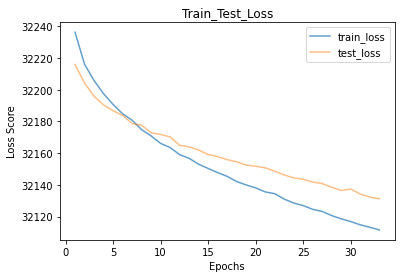

34
Train Epoch: 34 [0/7471 (0%)]	Loss: 32986.093750
Train Epoch: 34 [160/7471 (2%)]	Loss: 31997.410156
Train Epoch: 34 [320/7471 (4%)]	Loss: 31179.750000
Train Epoch: 34 [480/7471 (6%)]	Loss: 31923.308594
Train Epoch: 34 [640/7471 (9%)]	Loss: 31515.107422
Train Epoch: 34 [800/7471 (11%)]	Loss: 33135.578125
Train Epoch: 34 [960/7471 (13%)]	Loss: 30972.865234
Train Epoch: 34 [1120/7471 (15%)]	Loss: 32373.091797
Train Epoch: 34 [1280/7471 (17%)]	Loss: 30351.935547
Train Epoch: 34 [1440/7471 (19%)]	Loss: 30808.779297
Train Epoch: 34 [1600/7471 (21%)]	Loss: 31801.781250
Train Epoch: 34 [1760/7471 (24%)]	Loss: 32417.203125
Train Epoch: 34 [1920/7471 (26%)]	Loss: 32969.835938
Train Epoch: 34 [2080/7471 (28%)]	Loss: 33033.109375
Train Epoch: 34 [2240/7471 (30%)]	Loss: 32047.847656
Train Epoch: 34 [2400/7471 (32%)]	Loss: 33052.031250
Train Epoch: 34 [2560/7471 (34%)]	Loss: 32516.871094
Train Epoch: 34 [2720/7471 (36%)]	Loss: 31405.869141
Train Epoch: 34 [2880/7471 (39%)]	Loss: 32423.994141
Trai

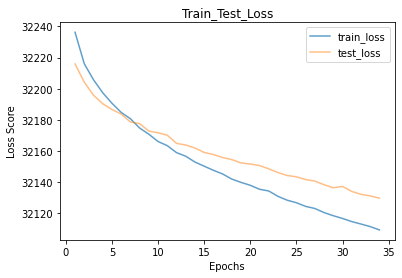

35
Train Epoch: 35 [0/7471 (0%)]	Loss: 32863.511719
Train Epoch: 35 [160/7471 (2%)]	Loss: 31319.380859
Train Epoch: 35 [320/7471 (4%)]	Loss: 32510.566406
Train Epoch: 35 [480/7471 (6%)]	Loss: 32279.011719
Train Epoch: 35 [640/7471 (9%)]	Loss: 33817.910156
Train Epoch: 35 [800/7471 (11%)]	Loss: 32179.371094
Train Epoch: 35 [960/7471 (13%)]	Loss: 32638.330078
Train Epoch: 35 [1120/7471 (15%)]	Loss: 32630.410156
Train Epoch: 35 [1280/7471 (17%)]	Loss: 29901.724609
Train Epoch: 35 [1440/7471 (19%)]	Loss: 32085.386719
Train Epoch: 35 [1600/7471 (21%)]	Loss: 32185.230469
Train Epoch: 35 [1760/7471 (24%)]	Loss: 31768.619141
Train Epoch: 35 [1920/7471 (26%)]	Loss: 32366.373047
Train Epoch: 35 [2080/7471 (28%)]	Loss: 32986.343750
Train Epoch: 35 [2240/7471 (30%)]	Loss: 31627.730469
Train Epoch: 35 [2400/7471 (32%)]	Loss: 32566.501953
Train Epoch: 35 [2560/7471 (34%)]	Loss: 33545.355469
Train Epoch: 35 [2720/7471 (36%)]	Loss: 32605.248047
Train Epoch: 35 [2880/7471 (39%)]	Loss: 31396.113281
Trai

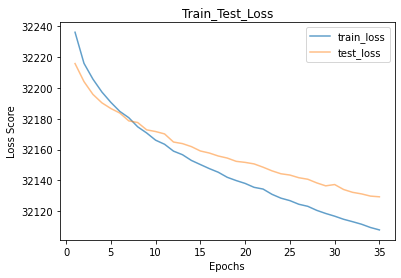

36
Train Epoch: 36 [0/7471 (0%)]	Loss: 30855.216797
Train Epoch: 36 [160/7471 (2%)]	Loss: 32579.861328
Train Epoch: 36 [320/7471 (4%)]	Loss: 31921.218750
Train Epoch: 36 [480/7471 (6%)]	Loss: 31584.810547
Train Epoch: 36 [640/7471 (9%)]	Loss: 31429.400391
Train Epoch: 36 [800/7471 (11%)]	Loss: 32941.792969
Train Epoch: 36 [960/7471 (13%)]	Loss: 31614.003906
Train Epoch: 36 [1120/7471 (15%)]	Loss: 32280.058594
Train Epoch: 36 [1280/7471 (17%)]	Loss: 32259.855469
Train Epoch: 36 [1440/7471 (19%)]	Loss: 32905.023438
Train Epoch: 36 [1600/7471 (21%)]	Loss: 33265.968750
Train Epoch: 36 [1760/7471 (24%)]	Loss: 33108.285156
Train Epoch: 36 [1920/7471 (26%)]	Loss: 32141.535156
Train Epoch: 36 [2080/7471 (28%)]	Loss: 32656.542969
Train Epoch: 36 [2240/7471 (30%)]	Loss: 32891.105469
Train Epoch: 36 [2400/7471 (32%)]	Loss: 31141.433594
Train Epoch: 36 [2560/7471 (34%)]	Loss: 32610.078125
Train Epoch: 36 [2720/7471 (36%)]	Loss: 32224.958984
Train Epoch: 36 [2880/7471 (39%)]	Loss: 31802.210938
Trai

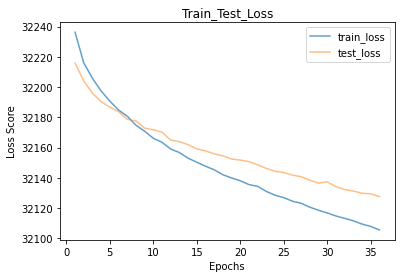

37
Train Epoch: 37 [0/7471 (0%)]	Loss: 33609.714844
Train Epoch: 37 [160/7471 (2%)]	Loss: 31598.431641
Train Epoch: 37 [320/7471 (4%)]	Loss: 29520.431641
Train Epoch: 37 [480/7471 (6%)]	Loss: 33316.773438
Train Epoch: 37 [640/7471 (9%)]	Loss: 31708.648438
Train Epoch: 37 [800/7471 (11%)]	Loss: 29900.365234
Train Epoch: 37 [960/7471 (13%)]	Loss: 31982.031250
Train Epoch: 37 [1120/7471 (15%)]	Loss: 32616.582031
Train Epoch: 37 [1280/7471 (17%)]	Loss: 33324.468750
Train Epoch: 37 [1440/7471 (19%)]	Loss: 30659.212891
Train Epoch: 37 [1600/7471 (21%)]	Loss: 32091.554688
Train Epoch: 37 [1760/7471 (24%)]	Loss: 31887.544922
Train Epoch: 37 [1920/7471 (26%)]	Loss: 29667.583984
Train Epoch: 37 [2080/7471 (28%)]	Loss: 30797.240234
Train Epoch: 37 [2240/7471 (30%)]	Loss: 32512.187500
Train Epoch: 37 [2400/7471 (32%)]	Loss: 30574.679688
Train Epoch: 37 [2560/7471 (34%)]	Loss: 30428.316406
Train Epoch: 37 [2720/7471 (36%)]	Loss: 32334.160156
Train Epoch: 37 [2880/7471 (39%)]	Loss: 30573.246094
Trai

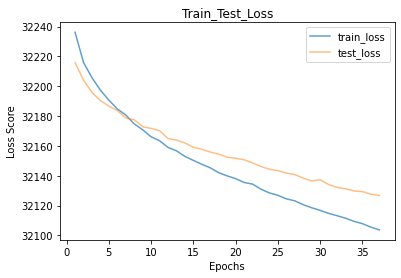

38
Train Epoch: 38 [0/7471 (0%)]	Loss: 32651.191406
Train Epoch: 38 [160/7471 (2%)]	Loss: 31068.751953
Train Epoch: 38 [320/7471 (4%)]	Loss: 33486.906250
Train Epoch: 38 [480/7471 (6%)]	Loss: 31781.113281
Train Epoch: 38 [640/7471 (9%)]	Loss: 30131.544922
Train Epoch: 38 [800/7471 (11%)]	Loss: 32601.873047
Train Epoch: 38 [960/7471 (13%)]	Loss: 32695.406250
Train Epoch: 38 [1120/7471 (15%)]	Loss: 31869.380859
Train Epoch: 38 [1280/7471 (17%)]	Loss: 32761.832031
Train Epoch: 38 [1440/7471 (19%)]	Loss: 32709.855469
Train Epoch: 38 [1600/7471 (21%)]	Loss: 33523.589844
Train Epoch: 38 [1760/7471 (24%)]	Loss: 32133.519531
Train Epoch: 38 [1920/7471 (26%)]	Loss: 31884.326172
Train Epoch: 38 [2080/7471 (28%)]	Loss: 31918.349609
Train Epoch: 38 [2240/7471 (30%)]	Loss: 32225.203125
Train Epoch: 38 [2400/7471 (32%)]	Loss: 31751.257812
Train Epoch: 38 [2560/7471 (34%)]	Loss: 32839.882812
Train Epoch: 38 [2720/7471 (36%)]	Loss: 31952.021484
Train Epoch: 38 [2880/7471 (39%)]	Loss: 31301.158203
Trai

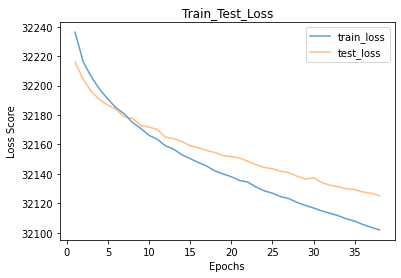

39
Train Epoch: 39 [0/7471 (0%)]	Loss: 31737.794922
Train Epoch: 39 [160/7471 (2%)]	Loss: 30324.037109
Train Epoch: 39 [320/7471 (4%)]	Loss: 31913.904297
Train Epoch: 39 [480/7471 (6%)]	Loss: 31824.759766
Train Epoch: 39 [640/7471 (9%)]	Loss: 33332.972656
Train Epoch: 39 [800/7471 (11%)]	Loss: 30105.781250
Train Epoch: 39 [960/7471 (13%)]	Loss: 30976.382812
Train Epoch: 39 [1120/7471 (15%)]	Loss: 31962.220703
Train Epoch: 39 [1280/7471 (17%)]	Loss: 34053.808594
Train Epoch: 39 [1440/7471 (19%)]	Loss: 32898.406250
Train Epoch: 39 [1600/7471 (21%)]	Loss: 32452.701172
Train Epoch: 39 [1760/7471 (24%)]	Loss: 33069.589844
Train Epoch: 39 [1920/7471 (26%)]	Loss: 31683.458984
Train Epoch: 39 [2080/7471 (28%)]	Loss: 32413.146484
Train Epoch: 39 [2240/7471 (30%)]	Loss: 31152.326172
Train Epoch: 39 [2400/7471 (32%)]	Loss: 33394.324219
Train Epoch: 39 [2560/7471 (34%)]	Loss: 32054.175781
Train Epoch: 39 [2720/7471 (36%)]	Loss: 31449.189453
Train Epoch: 39 [2880/7471 (39%)]	Loss: 29503.416016
Trai

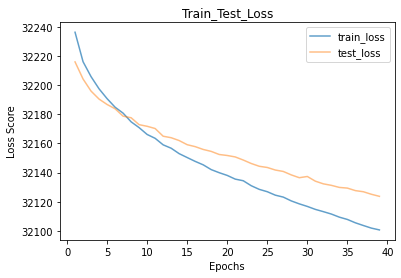

40
Train Epoch: 40 [0/7471 (0%)]	Loss: 31418.533203
Train Epoch: 40 [160/7471 (2%)]	Loss: 31918.199219
Train Epoch: 40 [320/7471 (4%)]	Loss: 32045.218750
Train Epoch: 40 [480/7471 (6%)]	Loss: 29499.806641
Train Epoch: 40 [640/7471 (9%)]	Loss: 32832.195312
Train Epoch: 40 [800/7471 (11%)]	Loss: 31454.892578
Train Epoch: 40 [960/7471 (13%)]	Loss: 32073.054688
Train Epoch: 40 [1120/7471 (15%)]	Loss: 31134.679688
Train Epoch: 40 [1280/7471 (17%)]	Loss: 32405.974609
Train Epoch: 40 [1440/7471 (19%)]	Loss: 32415.880859
Train Epoch: 40 [1600/7471 (21%)]	Loss: 33230.890625
Train Epoch: 40 [1760/7471 (24%)]	Loss: 31743.962891
Train Epoch: 40 [1920/7471 (26%)]	Loss: 30256.054688
Train Epoch: 40 [2080/7471 (28%)]	Loss: 30931.501953
Train Epoch: 40 [2240/7471 (30%)]	Loss: 31662.312500
Train Epoch: 40 [2400/7471 (32%)]	Loss: 33311.531250
Train Epoch: 40 [2560/7471 (34%)]	Loss: 32386.193359
Train Epoch: 40 [2720/7471 (36%)]	Loss: 32902.101562
Train Epoch: 40 [2880/7471 (39%)]	Loss: 32982.273438
Trai

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


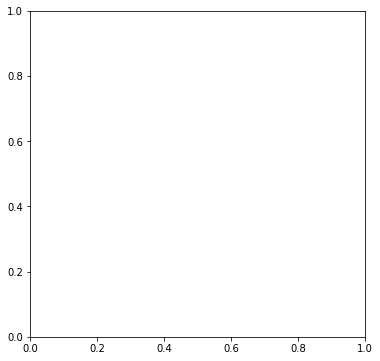

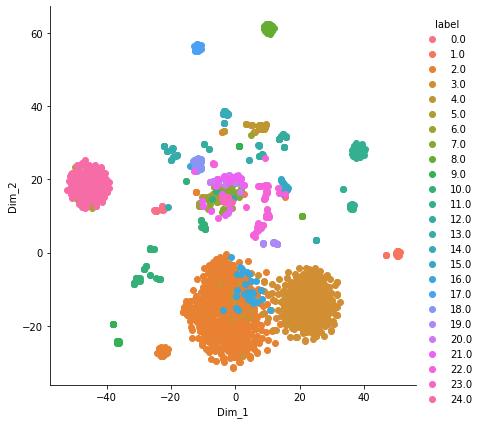

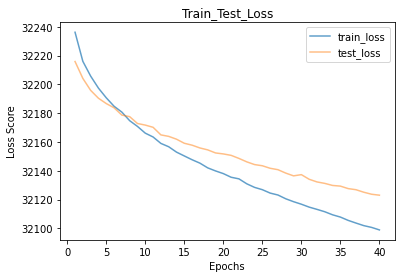

41
Train Epoch: 41 [0/7471 (0%)]	Loss: 31209.699219
Train Epoch: 41 [160/7471 (2%)]	Loss: 29436.636719
Train Epoch: 41 [320/7471 (4%)]	Loss: 30713.861328
Train Epoch: 41 [480/7471 (6%)]	Loss: 30704.154297
Train Epoch: 41 [640/7471 (9%)]	Loss: 32755.373047
Train Epoch: 41 [800/7471 (11%)]	Loss: 32698.748047
Train Epoch: 41 [960/7471 (13%)]	Loss: 31851.871094
Train Epoch: 41 [1120/7471 (15%)]	Loss: 31130.285156
Train Epoch: 41 [1280/7471 (17%)]	Loss: 32021.482422
Train Epoch: 41 [1440/7471 (19%)]	Loss: 31477.976562
Train Epoch: 41 [1600/7471 (21%)]	Loss: 32034.431641
Train Epoch: 41 [1760/7471 (24%)]	Loss: 32214.033203
Train Epoch: 41 [1920/7471 (26%)]	Loss: 31785.423828
Train Epoch: 41 [2080/7471 (28%)]	Loss: 33301.273438
Train Epoch: 41 [2240/7471 (30%)]	Loss: 33655.222656
Train Epoch: 41 [2400/7471 (32%)]	Loss: 32323.207031
Train Epoch: 41 [2560/7471 (34%)]	Loss: 31694.330078
Train Epoch: 41 [2720/7471 (36%)]	Loss: 30821.912109
Train Epoch: 41 [2880/7471 (39%)]	Loss: 31961.287109
Trai

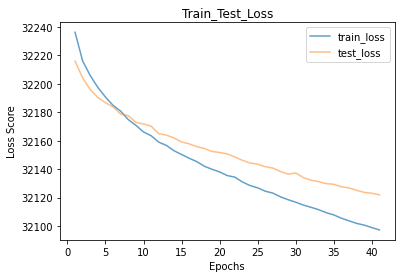

42
Train Epoch: 42 [0/7471 (0%)]	Loss: 32015.003906
Train Epoch: 42 [160/7471 (2%)]	Loss: 31721.320312
Train Epoch: 42 [320/7471 (4%)]	Loss: 33417.750000
Train Epoch: 42 [480/7471 (6%)]	Loss: 32753.960938
Train Epoch: 42 [640/7471 (9%)]	Loss: 31341.527344
Train Epoch: 42 [800/7471 (11%)]	Loss: 31400.406250
Train Epoch: 42 [960/7471 (13%)]	Loss: 33235.613281
Train Epoch: 42 [1120/7471 (15%)]	Loss: 33121.285156
Train Epoch: 42 [1280/7471 (17%)]	Loss: 33098.496094
Train Epoch: 42 [1440/7471 (19%)]	Loss: 33189.886719
Train Epoch: 42 [1600/7471 (21%)]	Loss: 32632.523438
Train Epoch: 42 [1760/7471 (24%)]	Loss: 32985.070312
Train Epoch: 42 [1920/7471 (26%)]	Loss: 33133.992188
Train Epoch: 42 [2080/7471 (28%)]	Loss: 31582.404297
Train Epoch: 42 [2240/7471 (30%)]	Loss: 32487.982422
Train Epoch: 42 [2400/7471 (32%)]	Loss: 31461.941406
Train Epoch: 42 [2560/7471 (34%)]	Loss: 32287.843750
Train Epoch: 42 [2720/7471 (36%)]	Loss: 32763.285156
Train Epoch: 42 [2880/7471 (39%)]	Loss: 32664.652344
Trai

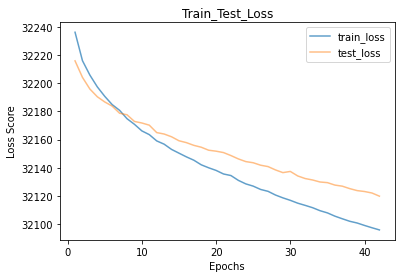

43
Train Epoch: 43 [0/7471 (0%)]	Loss: 31748.050781
Train Epoch: 43 [160/7471 (2%)]	Loss: 30327.105469
Train Epoch: 43 [320/7471 (4%)]	Loss: 33043.804688
Train Epoch: 43 [480/7471 (6%)]	Loss: 32715.646484
Train Epoch: 43 [640/7471 (9%)]	Loss: 33642.183594
Train Epoch: 43 [800/7471 (11%)]	Loss: 32203.412109
Train Epoch: 43 [960/7471 (13%)]	Loss: 32051.115234
Train Epoch: 43 [1120/7471 (15%)]	Loss: 32868.984375
Train Epoch: 43 [1280/7471 (17%)]	Loss: 31955.179688
Train Epoch: 43 [1440/7471 (19%)]	Loss: 32141.501953
Train Epoch: 43 [1600/7471 (21%)]	Loss: 31658.220703
Train Epoch: 43 [1760/7471 (24%)]	Loss: 32482.658203
Train Epoch: 43 [1920/7471 (26%)]	Loss: 32080.341797
Train Epoch: 43 [2080/7471 (28%)]	Loss: 33341.914062
Train Epoch: 43 [2240/7471 (30%)]	Loss: 30408.128906
Train Epoch: 43 [2400/7471 (32%)]	Loss: 33465.867188
Train Epoch: 43 [2560/7471 (34%)]	Loss: 30990.509766
Train Epoch: 43 [2720/7471 (36%)]	Loss: 32581.953125
Train Epoch: 43 [2880/7471 (39%)]	Loss: 32355.150391
Trai

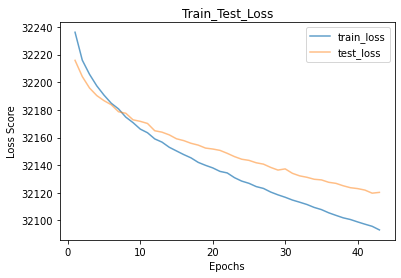

44
Train Epoch: 44 [0/7471 (0%)]	Loss: 33265.265625
Train Epoch: 44 [160/7471 (2%)]	Loss: 31753.812500
Train Epoch: 44 [320/7471 (4%)]	Loss: 31782.812500
Train Epoch: 44 [480/7471 (6%)]	Loss: 31910.785156
Train Epoch: 44 [640/7471 (9%)]	Loss: 33482.468750
Train Epoch: 44 [800/7471 (11%)]	Loss: 32245.058594
Train Epoch: 44 [960/7471 (13%)]	Loss: 32197.667969
Train Epoch: 44 [1120/7471 (15%)]	Loss: 31723.187500
Train Epoch: 44 [1280/7471 (17%)]	Loss: 32451.193359
Train Epoch: 44 [1440/7471 (19%)]	Loss: 31953.648438
Train Epoch: 44 [1600/7471 (21%)]	Loss: 32143.693359
Train Epoch: 44 [1760/7471 (24%)]	Loss: 31927.876953
Train Epoch: 44 [1920/7471 (26%)]	Loss: 32457.591797
Train Epoch: 44 [2080/7471 (28%)]	Loss: 31235.169922
Train Epoch: 44 [2240/7471 (30%)]	Loss: 31470.144531
Train Epoch: 44 [2400/7471 (32%)]	Loss: 32493.738281
Train Epoch: 44 [2560/7471 (34%)]	Loss: 30541.900391
Train Epoch: 44 [2720/7471 (36%)]	Loss: 30705.390625
Train Epoch: 44 [2880/7471 (39%)]	Loss: 30801.667969
Trai

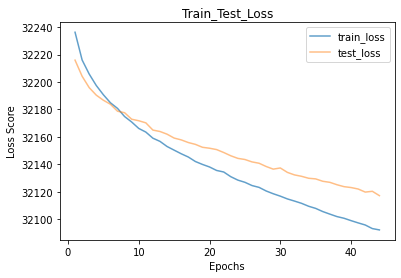

45
Train Epoch: 45 [0/7471 (0%)]	Loss: 31788.753906
Train Epoch: 45 [160/7471 (2%)]	Loss: 31284.548828
Train Epoch: 45 [320/7471 (4%)]	Loss: 32426.017578
Train Epoch: 45 [480/7471 (6%)]	Loss: 32101.111328
Train Epoch: 45 [640/7471 (9%)]	Loss: 32822.941406
Train Epoch: 45 [800/7471 (11%)]	Loss: 33611.632812
Train Epoch: 45 [960/7471 (13%)]	Loss: 33143.308594
Train Epoch: 45 [1120/7471 (15%)]	Loss: 33241.640625
Train Epoch: 45 [1280/7471 (17%)]	Loss: 31532.873047
Train Epoch: 45 [1440/7471 (19%)]	Loss: 32512.259766
Train Epoch: 45 [1600/7471 (21%)]	Loss: 32971.843750
Train Epoch: 45 [1760/7471 (24%)]	Loss: 30751.410156
Train Epoch: 45 [1920/7471 (26%)]	Loss: 32964.789062
Train Epoch: 45 [2080/7471 (28%)]	Loss: 30797.539062
Train Epoch: 45 [2240/7471 (30%)]	Loss: 32088.365234
Train Epoch: 45 [2400/7471 (32%)]	Loss: 33385.707031
Train Epoch: 45 [2560/7471 (34%)]	Loss: 32150.378906
Train Epoch: 45 [2720/7471 (36%)]	Loss: 32052.177734
Train Epoch: 45 [2880/7471 (39%)]	Loss: 31846.603516
Trai

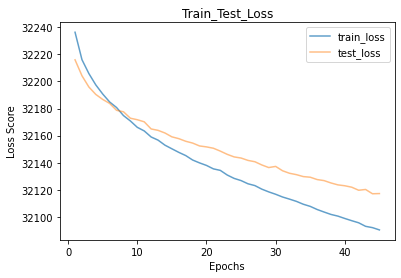

46
Train Epoch: 46 [0/7471 (0%)]	Loss: 31226.927734
Train Epoch: 46 [160/7471 (2%)]	Loss: 31366.181641
Train Epoch: 46 [320/7471 (4%)]	Loss: 32647.849609
Train Epoch: 46 [480/7471 (6%)]	Loss: 31782.597656
Train Epoch: 46 [640/7471 (9%)]	Loss: 31210.548828
Train Epoch: 46 [800/7471 (11%)]	Loss: 33180.558594
Train Epoch: 46 [960/7471 (13%)]	Loss: 32847.113281
Train Epoch: 46 [1120/7471 (15%)]	Loss: 33099.144531
Train Epoch: 46 [1280/7471 (17%)]	Loss: 31903.332031
Train Epoch: 46 [1440/7471 (19%)]	Loss: 31771.839844
Train Epoch: 46 [1600/7471 (21%)]	Loss: 33626.550781
Train Epoch: 46 [1760/7471 (24%)]	Loss: 30208.757812
Train Epoch: 46 [1920/7471 (26%)]	Loss: 31942.125000
Train Epoch: 46 [2080/7471 (28%)]	Loss: 33208.980469
Train Epoch: 46 [2240/7471 (30%)]	Loss: 32530.066406
Train Epoch: 46 [2400/7471 (32%)]	Loss: 32243.552734
Train Epoch: 46 [2560/7471 (34%)]	Loss: 32579.640625
Train Epoch: 46 [2720/7471 (36%)]	Loss: 31342.144531
Train Epoch: 46 [2880/7471 (39%)]	Loss: 31015.931641
Trai

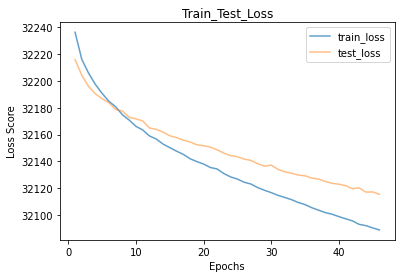

47
Train Epoch: 47 [0/7471 (0%)]	Loss: 32507.025391
Train Epoch: 47 [160/7471 (2%)]	Loss: 31925.015625
Train Epoch: 47 [320/7471 (4%)]	Loss: 32264.281250
Train Epoch: 47 [480/7471 (6%)]	Loss: 31752.435547
Train Epoch: 47 [640/7471 (9%)]	Loss: 30818.193359
Train Epoch: 47 [800/7471 (11%)]	Loss: 31417.710938
Train Epoch: 47 [960/7471 (13%)]	Loss: 33022.000000
Train Epoch: 47 [1120/7471 (15%)]	Loss: 30845.820312
Train Epoch: 47 [1280/7471 (17%)]	Loss: 30911.000000
Train Epoch: 47 [1440/7471 (19%)]	Loss: 31634.367188
Train Epoch: 47 [1600/7471 (21%)]	Loss: 32487.232422
Train Epoch: 47 [1760/7471 (24%)]	Loss: 31995.304688
Train Epoch: 47 [1920/7471 (26%)]	Loss: 32954.671875
Train Epoch: 47 [2080/7471 (28%)]	Loss: 31526.843750
Train Epoch: 47 [2240/7471 (30%)]	Loss: 32389.808594
Train Epoch: 47 [2400/7471 (32%)]	Loss: 31653.503906
Train Epoch: 47 [2560/7471 (34%)]	Loss: 31483.048828
Train Epoch: 47 [2720/7471 (36%)]	Loss: 32699.783203
Train Epoch: 47 [2880/7471 (39%)]	Loss: 32693.109375
Trai

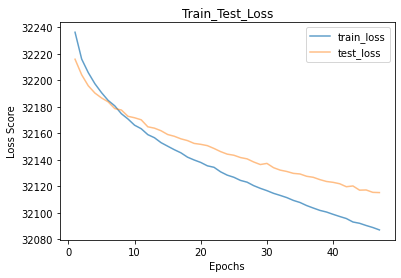

48
Train Epoch: 48 [0/7471 (0%)]	Loss: 31899.316406
Train Epoch: 48 [160/7471 (2%)]	Loss: 32785.375000
Train Epoch: 48 [320/7471 (4%)]	Loss: 32115.541016
Train Epoch: 48 [480/7471 (6%)]	Loss: 30702.990234
Train Epoch: 48 [640/7471 (9%)]	Loss: 32338.933594
Train Epoch: 48 [800/7471 (11%)]	Loss: 31032.548828
Train Epoch: 48 [960/7471 (13%)]	Loss: 33089.292969
Train Epoch: 48 [1120/7471 (15%)]	Loss: 32173.244141
Train Epoch: 48 [1280/7471 (17%)]	Loss: 32351.449219
Train Epoch: 48 [1440/7471 (19%)]	Loss: 32236.343750
Train Epoch: 48 [1600/7471 (21%)]	Loss: 32547.662109
Train Epoch: 48 [1760/7471 (24%)]	Loss: 32971.792969
Train Epoch: 48 [1920/7471 (26%)]	Loss: 30014.166016
Train Epoch: 48 [2080/7471 (28%)]	Loss: 33176.062500
Train Epoch: 48 [2240/7471 (30%)]	Loss: 31286.294922
Train Epoch: 48 [2400/7471 (32%)]	Loss: 31012.064453
Train Epoch: 48 [2560/7471 (34%)]	Loss: 32617.111328
Train Epoch: 48 [2720/7471 (36%)]	Loss: 31610.710938
Train Epoch: 48 [2880/7471 (39%)]	Loss: 31485.121094
Trai

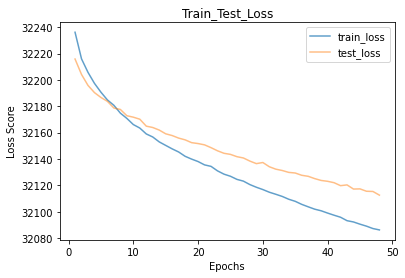

49
Train Epoch: 49 [0/7471 (0%)]	Loss: 31859.796875
Train Epoch: 49 [160/7471 (2%)]	Loss: 33158.125000
Train Epoch: 49 [320/7471 (4%)]	Loss: 32035.109375
Train Epoch: 49 [480/7471 (6%)]	Loss: 30403.951172
Train Epoch: 49 [640/7471 (9%)]	Loss: 32384.445312
Train Epoch: 49 [800/7471 (11%)]	Loss: 30574.978516
Train Epoch: 49 [960/7471 (13%)]	Loss: 31431.332031
Train Epoch: 49 [1120/7471 (15%)]	Loss: 30594.976562
Train Epoch: 49 [1280/7471 (17%)]	Loss: 31106.451172
Train Epoch: 49 [1440/7471 (19%)]	Loss: 33014.039062
Train Epoch: 49 [1600/7471 (21%)]	Loss: 33486.363281
Train Epoch: 49 [1760/7471 (24%)]	Loss: 32816.507812
Train Epoch: 49 [1920/7471 (26%)]	Loss: 31648.238281
Train Epoch: 49 [2080/7471 (28%)]	Loss: 32294.345703
Train Epoch: 49 [2240/7471 (30%)]	Loss: 32132.187500
Train Epoch: 49 [2400/7471 (32%)]	Loss: 31274.761719
Train Epoch: 49 [2560/7471 (34%)]	Loss: 33878.679688
Train Epoch: 49 [2720/7471 (36%)]	Loss: 33043.496094
Train Epoch: 49 [2880/7471 (39%)]	Loss: 31847.285156
Trai

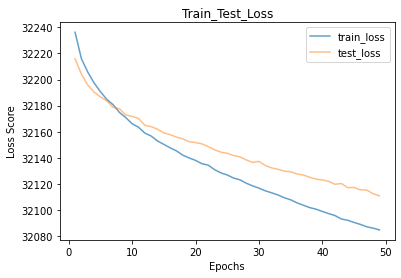

50
Train Epoch: 50 [0/7471 (0%)]	Loss: 32485.373047
Train Epoch: 50 [160/7471 (2%)]	Loss: 30631.271484
Train Epoch: 50 [320/7471 (4%)]	Loss: 32810.101562
Train Epoch: 50 [480/7471 (6%)]	Loss: 31390.009766
Train Epoch: 50 [640/7471 (9%)]	Loss: 33151.847656
Train Epoch: 50 [800/7471 (11%)]	Loss: 33006.402344
Train Epoch: 50 [960/7471 (13%)]	Loss: 32480.048828
Train Epoch: 50 [1120/7471 (15%)]	Loss: 33445.476562
Train Epoch: 50 [1280/7471 (17%)]	Loss: 32747.771484
Train Epoch: 50 [1440/7471 (19%)]	Loss: 31957.201172
Train Epoch: 50 [1600/7471 (21%)]	Loss: 33642.140625
Train Epoch: 50 [1760/7471 (24%)]	Loss: 32576.523438
Train Epoch: 50 [1920/7471 (26%)]	Loss: 31331.115234
Train Epoch: 50 [2080/7471 (28%)]	Loss: 33005.878906
Train Epoch: 50 [2240/7471 (30%)]	Loss: 31453.517578
Train Epoch: 50 [2400/7471 (32%)]	Loss: 32178.050781
Train Epoch: 50 [2560/7471 (34%)]	Loss: 32649.232422
Train Epoch: 50 [2720/7471 (36%)]	Loss: 31071.294922
Train Epoch: 50 [2880/7471 (39%)]	Loss: 33284.843750
Trai

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


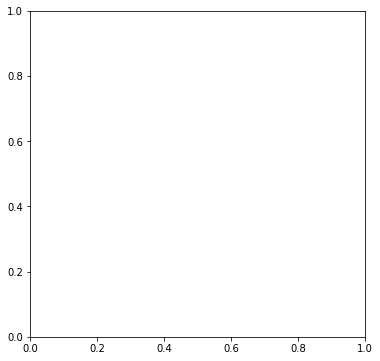

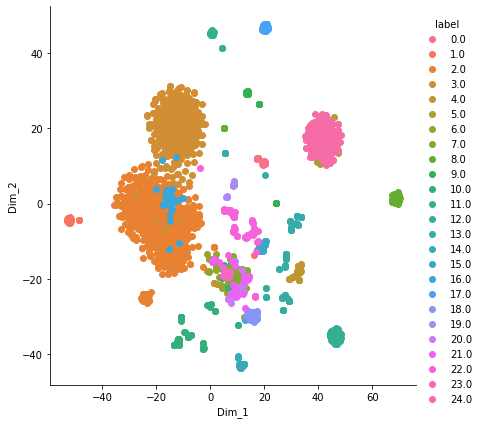

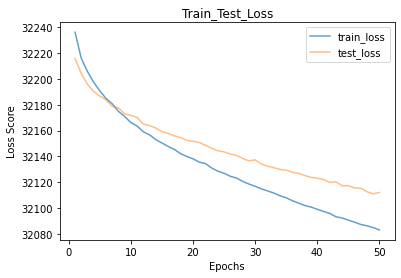

51
Train Epoch: 51 [0/7471 (0%)]	Loss: 32646.587891
Train Epoch: 51 [160/7471 (2%)]	Loss: 33060.816406
Train Epoch: 51 [320/7471 (4%)]	Loss: 31102.806641
Train Epoch: 51 [480/7471 (6%)]	Loss: 30927.527344
Train Epoch: 51 [640/7471 (9%)]	Loss: 31739.111328
Train Epoch: 51 [800/7471 (11%)]	Loss: 32910.406250
Train Epoch: 51 [960/7471 (13%)]	Loss: 33630.507812
Train Epoch: 51 [1120/7471 (15%)]	Loss: 32952.851562
Train Epoch: 51 [1280/7471 (17%)]	Loss: 33487.378906
Train Epoch: 51 [1440/7471 (19%)]	Loss: 32280.777344
Train Epoch: 51 [1600/7471 (21%)]	Loss: 32823.066406
Train Epoch: 51 [1760/7471 (24%)]	Loss: 33310.148438
Train Epoch: 51 [1920/7471 (26%)]	Loss: 33861.390625
Train Epoch: 51 [2080/7471 (28%)]	Loss: 32772.410156
Train Epoch: 51 [2240/7471 (30%)]	Loss: 31547.816406
Train Epoch: 51 [2400/7471 (32%)]	Loss: 33179.812500
Train Epoch: 51 [2560/7471 (34%)]	Loss: 32118.166016
Train Epoch: 51 [2720/7471 (36%)]	Loss: 31312.341797
Train Epoch: 51 [2880/7471 (39%)]	Loss: 33189.804688
Trai

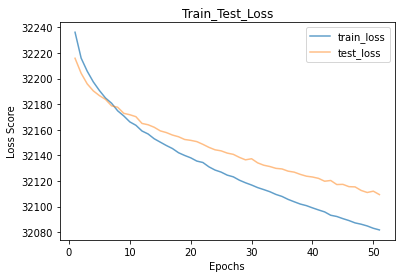

52
Train Epoch: 52 [0/7471 (0%)]	Loss: 33247.914062
Train Epoch: 52 [160/7471 (2%)]	Loss: 32518.054688
Train Epoch: 52 [320/7471 (4%)]	Loss: 31219.904297
Train Epoch: 52 [480/7471 (6%)]	Loss: 32912.683594
Train Epoch: 52 [640/7471 (9%)]	Loss: 31402.732422
Train Epoch: 52 [800/7471 (11%)]	Loss: 31704.253906
Train Epoch: 52 [960/7471 (13%)]	Loss: 31890.859375
Train Epoch: 52 [1120/7471 (15%)]	Loss: 31627.519531
Train Epoch: 52 [1280/7471 (17%)]	Loss: 31303.957031
Train Epoch: 52 [1440/7471 (19%)]	Loss: 31497.242188
Train Epoch: 52 [1600/7471 (21%)]	Loss: 33346.792969
Train Epoch: 52 [1760/7471 (24%)]	Loss: 31892.345703
Train Epoch: 52 [1920/7471 (26%)]	Loss: 32395.638672
Train Epoch: 52 [2080/7471 (28%)]	Loss: 32063.929688
Train Epoch: 52 [2240/7471 (30%)]	Loss: 32136.160156
Train Epoch: 52 [2400/7471 (32%)]	Loss: 33600.886719
Train Epoch: 52 [2560/7471 (34%)]	Loss: 33281.210938
Train Epoch: 52 [2720/7471 (36%)]	Loss: 30794.224609
Train Epoch: 52 [2880/7471 (39%)]	Loss: 32922.390625
Trai

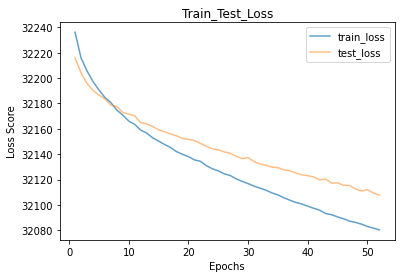

53
Train Epoch: 53 [0/7471 (0%)]	Loss: 32377.835938
Train Epoch: 53 [160/7471 (2%)]	Loss: 32741.861328
Train Epoch: 53 [320/7471 (4%)]	Loss: 32287.341797
Train Epoch: 53 [480/7471 (6%)]	Loss: 31315.273438
Train Epoch: 53 [640/7471 (9%)]	Loss: 31768.068359
Train Epoch: 53 [800/7471 (11%)]	Loss: 31862.994141
Train Epoch: 53 [960/7471 (13%)]	Loss: 32442.185547
Train Epoch: 53 [1120/7471 (15%)]	Loss: 32061.593750
Train Epoch: 53 [1280/7471 (17%)]	Loss: 30809.007812
Train Epoch: 53 [1440/7471 (19%)]	Loss: 31341.785156
Train Epoch: 53 [1600/7471 (21%)]	Loss: 32736.369141
Train Epoch: 53 [1760/7471 (24%)]	Loss: 33886.425781
Train Epoch: 53 [1920/7471 (26%)]	Loss: 31774.751953
Train Epoch: 53 [2080/7471 (28%)]	Loss: 32216.396484
Train Epoch: 53 [2240/7471 (30%)]	Loss: 32625.626953
Train Epoch: 53 [2400/7471 (32%)]	Loss: 31540.386719
Train Epoch: 53 [2560/7471 (34%)]	Loss: 31991.558594
Train Epoch: 53 [2720/7471 (36%)]	Loss: 32968.562500
Train Epoch: 53 [2880/7471 (39%)]	Loss: 33273.433594
Trai

In [ ]:
epochs = 60

for epoch in range(1, epochs + 1):
        print(epoch)
        train(epoch)
        test(epoch)
        # https://stackoverflow.com/questions/40766909/suggestions-to-plot-overlapping-lines-in-matplotlib
        plt.plot(Epoch_Loss['train_epoch'],Epoch_Loss['train_loss'], label="train_loss", alpha=0.7)
        plt.plot(Epoch_Loss['test_epoch'],Epoch_Loss['test_loss'], label="test_loss", alpha=0.5)
        plt.xlabel('Epochs')
        plt.ylabel('Loss Score')
        plt.title('Train_Test_Loss')
        plt.legend()
        plt.savefig('./Exp06_results/plot_train_test_loss/'+str(epoch)+'_epoch.png', dpi=300)
        plt.show()

        with torch.no_grad():
            sample = torch.randn(64, 100).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 224, 224),
                       './Exp06_results/recon_sampling/sampling_' + str(epoch) + '.png')

### Training 일지

1. Loss값이 수렴된 이후 Learning rate를 줄여 학습하면 어떻게 될까?
 

 * 이번 실험의 결과도 기대가 된다